# 0.0. Imports

In [3]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [164]:
from datetime import datetime

import inflection
import joblib
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import Image

from matplotlib import pyplot as plt

from scipy import stats as ss

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC

from xgboost import XGBClassifier

import utils

# 0.1. Helper Functions and Configurations

In [5]:
SEED = 42
NUMERICAL_DROP = ['row_number', 'exited']
CATEGORICAL_DROP = ['surname']

plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 24
sns.set(rc={'figure.figsize': (25, 12)})

In [6]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1)*(r - 1) / (n - 1))
    
    kcorr = k - (k - 1)**2 / (n - 1)
    rcorr = r - (k - 1)**2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1))) 

In [7]:
def unite_features_target(features, target):
    return pd.concat([features, target], axis = 1)

In [8]:
def split_features_target(dataframe):
    X_train = dataframe.drop(['exited'], axis = 1)
    y_train = dataframe.loc[:, 'exited']
    
    return X_train, y_train

In [9]:
def show_dataframe_dimensions(dataframe):
    print(f"Number of Rows: {dataframe.shape[0]}")
    print(f"Number of Columns: {dataframe.shape[1]}")
    
    return None

In [10]:
def get_numerical_attributes(dataframe):
    return dataframe.select_dtypes(include=['int64', 'float64']).drop(NUMERICAL_DROP, axis=1)

In [11]:
def get_categorical_attributes(dataframe):
    return dataframe.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).drop(CATEGORICAL_DROP, axis=1)

In [12]:
def get_first_order_statistics(dataframe):
    # Central Tendency Metrics
    mean = pd.DataFrame(dataframe.apply(np.mean)).T
    median = pd.DataFrame(dataframe.apply(np.median)).T

    # Dispersion Metrics
    min_ = pd.DataFrame(dataframe.apply(min)).T
    max_ = pd.DataFrame(dataframe.apply(max)).T
    range_ = pd.DataFrame(dataframe.apply(lambda x: x.max() - x.min())).T
    std = pd.DataFrame(dataframe.apply(np.std)).T
    skew = pd.DataFrame(dataframe.apply(lambda x: x.skew())).T
    kurtosis = pd.DataFrame(dataframe.apply(lambda x: x.kurtosis())).T

    # Metrics Concatenation
    m = pd.concat([min_, max_, range_, mean, median, std, skew, kurtosis]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    display(m)
    
    return None

# 0.2. Load Data

In [13]:
df_raw = pd.read_csv('../data/training/abandono_clientes.csv')
df_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# 0.3. Data Split

In [14]:
# Sorting Data and Terget
target = df_raw.Exited
data = df_raw.drop('Exited', axis=1)

# Spliting Data
X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=0.80, test_size=0.20, random_state=SEED, stratify=target)

print(f'Train Size: {X_train.shape[0]} ({(X_train.shape[0]/df_raw.shape[0])*100}%)')
print(f'Train Size: {X_test.shape[0]} ({(X_test.shape[0]/df_raw.shape[0])*100}%)')

Train Size: 8000 (80.0%)
Train Size: 2000 (20.0%)


# 1.0. Data Description

In [15]:
df1 = unite_features_target(X_train, y_train)
df1.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2151,2152,15588614,Walton,753,France,Male,57,7,0.00,1,1,0,159475.08,1
8392,8393,15641158,Belcher,739,Germany,Male,32,3,102128.27,1,1,0,63981.37,1
5006,5007,15750014,Chikere,755,Germany,Female,37,0,113865.23,2,1,1,117396.25,0
4117,4118,15663964,Pagnotto,561,France,Male,37,5,0.00,2,1,0,83093.25,0
7182,7183,15573520,Rhodes,692,Germany,Male,49,6,110540.43,2,0,1,107472.99,0


## 1.1. Columns Description

| Column | Description |
| :----- | :---------- |
| `RowNumber` | Row ID |
| `CustomerId` | Customer ID |
| `Surname` | Customer's Last name |
| `CreditScore` | Customer Credit Score |
| `Geography` | Customer's Country of Residence |
| `Gender` | Costumer Gender |
| `Age` | Costumer Age |
| `Tenure` | Quantity of years that customer is a institution client |
| `Balande` | How much money the client have on it's account |
| `NumOfProducts` | Quantity of products that the client had purchased with the institution |
| `HasCrCard` | Indicates if the client has a credit card or not with the institution. 1 - client has credit card; 0 - client dosen't have credit card |
| `IsActiveMember` | Indicates if the client is active or not. 1 - active client; 0 - non active client |
| `EstimatedSalary` | Client's estimated anual salary |
| `Exited` | Indicates whether the client has an account at the institution. 1 - Client has exited instittion; 0 - client dosen't have exited institution |

## 1.2. Rename Columns

In [16]:
class RenameDataframeColumns_(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = self.rename_columns(X)
        
        return X
    
    def rename_columns(self, dataframe):
        # Copy DataFrame
        df = dataframe.copy()
        
        # Columns Names
        cols_old = list(df.columns)

        # Function to convert columns names to snake_case pattern
        snakecase = lambda x: inflection.underscore(x)

        # New columns names
        cols_new = list(map(snakecase, cols_old))

        # Apply new columns names to DataFrame
        df.columns = cols_new
        
        return df

In [17]:
rename_pipe = Pipeline([
    ('rename', utils.RenameDataframeColumns())
])

df1 = rename_pipe.fit_transform(df1)
df1.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
2151,2152,15588614,Walton,753,France,Male,57,7,0.00,1,1,0,159475.08,1
8392,8393,15641158,Belcher,739,Germany,Male,32,3,102128.27,1,1,0,63981.37,1
5006,5007,15750014,Chikere,755,Germany,Female,37,0,113865.23,2,1,1,117396.25,0
4117,4118,15663964,Pagnotto,561,France,Male,37,5,0.00,2,1,0,83093.25,0
7182,7183,15573520,Rhodes,692,Germany,Male,49,6,110540.43,2,0,1,107472.99,0


## 1.3. Data Dimensions

In [18]:
show_dataframe_dimensions(df1)

Number of Rows: 8000
Number of Columns: 14


## 1.4. Data Types

In [19]:
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.5. Check NA

In [20]:
df1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.6. Fill out NAs

There's no need to fill NA in this data set

## 1.7. Change Data Types

There's no need to change data types

## 1.8. Descriptive Statistics

### 1.8.1. Numeric and Categoric Separation

In [21]:
num_attributes = get_numerical_attributes(df1)
cat_attributes = get_categorical_attributes(df1)

#### 1.8.1.1. Numericas Attributes

In [22]:
get_first_order_statistics(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,customer_id,15565701.00,15815690.00,249989.00,1.569088e+07,1.568995e+07,71931.689685,0.006936,-1.196055
1,credit_score,350.00,850.00,500.00,6.507525e+02,6.520000e+02,96.590394,-0.079540,-0.418624
2,age,18.00,92.00,74.00,3.894662e+01,3.700000e+01,10.526219,1.035706,1.459448
3,tenure,0.00,10.00,10.00,5.016625e+00,5.000000e+00,2.896610,0.013124,-1.172842
4,balance,0.00,238387.56,238387.56,7.638121e+04,9.705515e+04,62298.159597,-0.141721,-1.492209
5,num_of_products,1.00,4.00,3.00,1.529500e+00,1.000000e+00,0.581704,0.755984,0.636943
6,has_cr_card,0.00,1.00,1.00,7.087500e-01,1.000000e+00,0.454338,-0.919091,-1.155561
7,is_active_member,0.00,1.00,1.00,5.148750e-01,1.000000e+00,0.499779,-0.059538,-1.996955
8,estimated_salary,11.58,199992.48,199980.90,9.973081e+04,9.944694e+04,57331.532983,0.007126,-1.174789


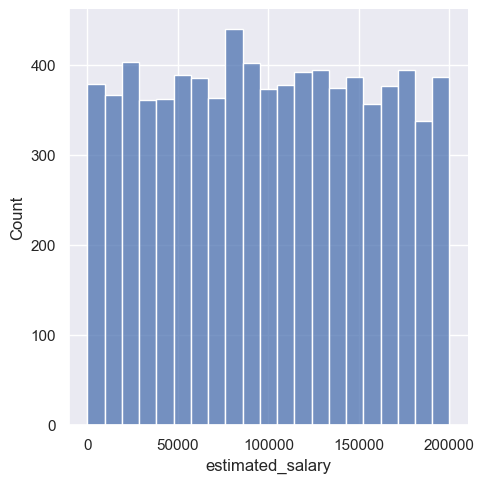

In [23]:
sns.displot( df1['estimated_salary'], kde=False );

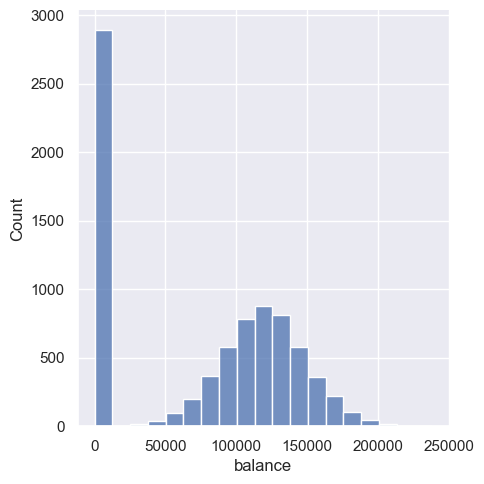

In [24]:
sns.displot( df1['balance'], kde=False );

#### 1.8.1.2. Categorical Attributes

In [25]:
cat_attributes.apply(lambda x: x.unique().shape[0])

geography    3
gender       2
dtype: int64

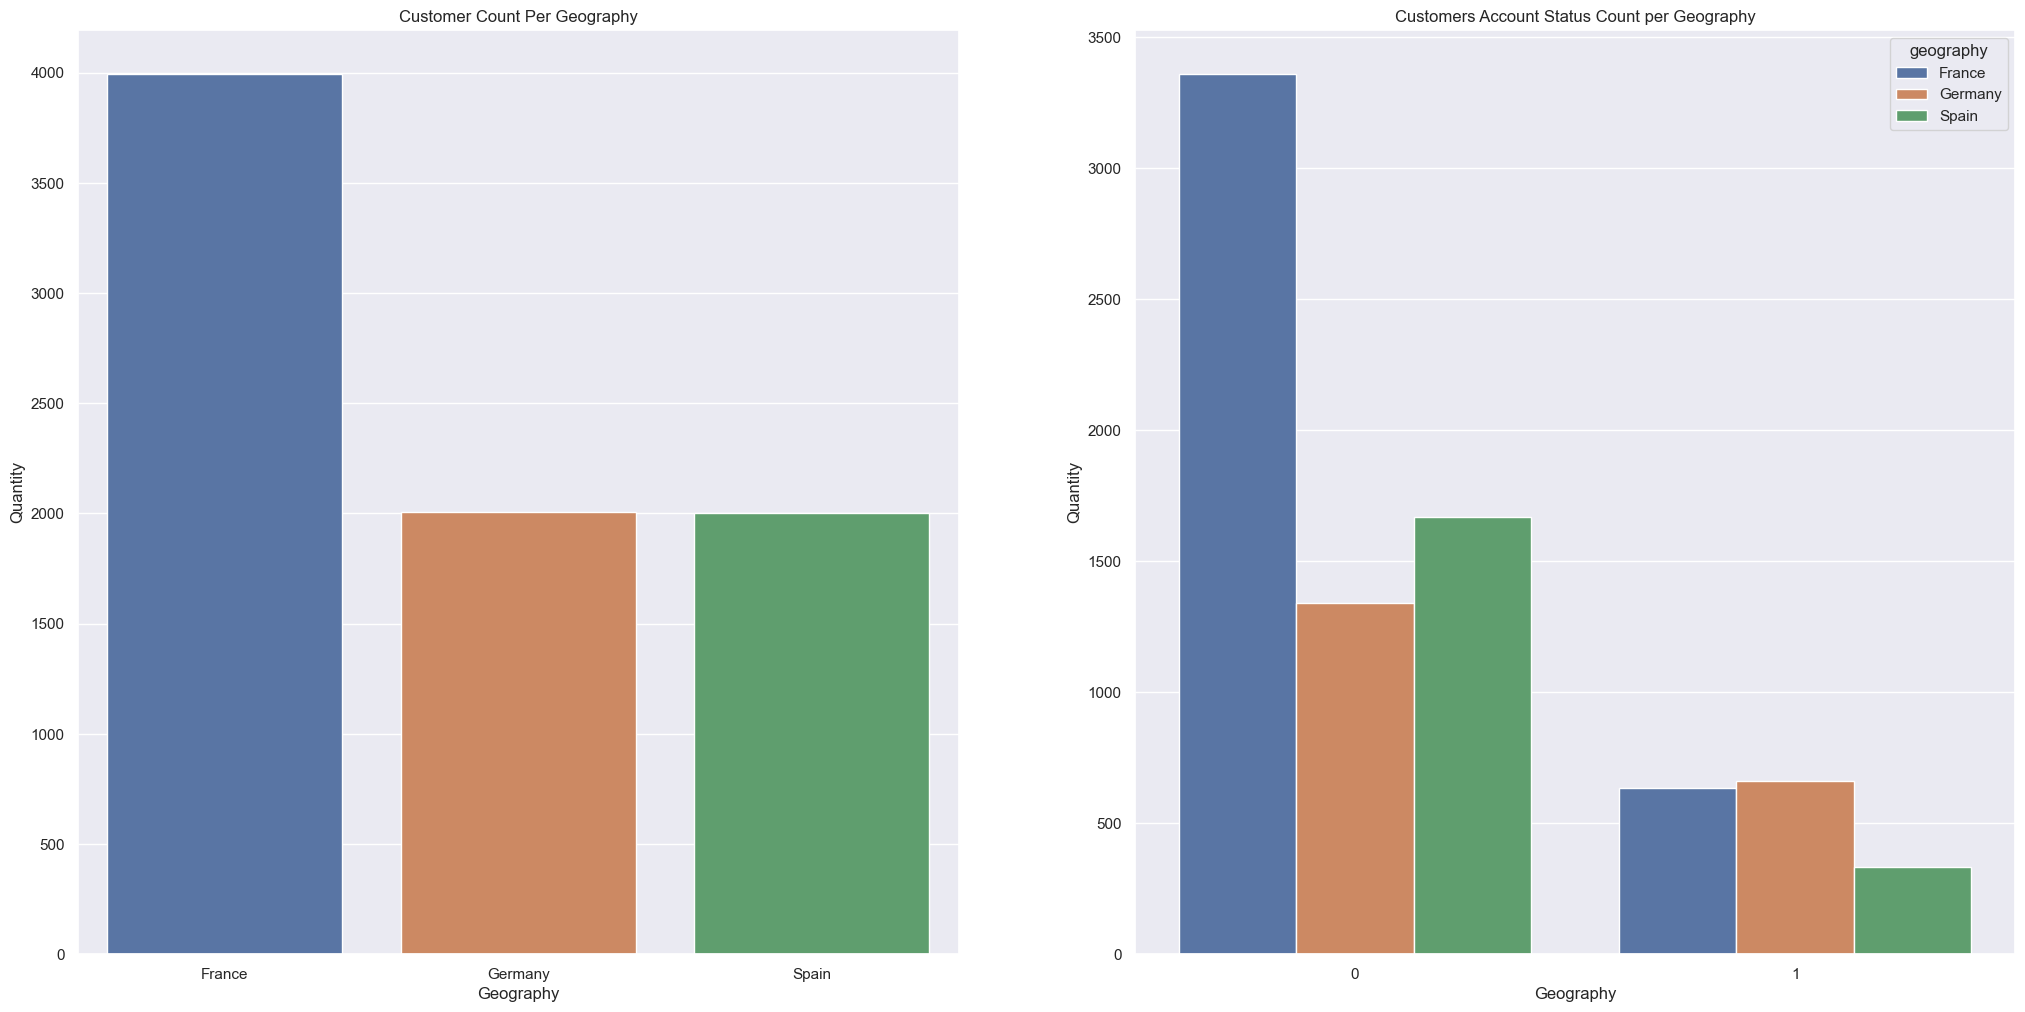

In [26]:
geography = df1.loc[ :, ['row_number', 'geography'] ].groupby(['geography']).count().reset_index()
ext_geography = df1.loc[ :, ['row_number', 'exited', 'geography'] ].groupby(['exited', 'geography']).count().reset_index()

plt.subplot(1, 2, 1)
ax = sns.barplot(x='geography', y='row_number', data=geography)
ax.set(title='Customer Count Per Geography', xlabel='Geography', ylabel='Quantity');

plt.subplot(1, 2, 2)
ax = sns.barplot(x='exited', y='row_number', data=ext_geography, hue='geography');
ax.set(title='Customers Account Status Count per Geography', xlabel='Geography', ylabel='Quantity');

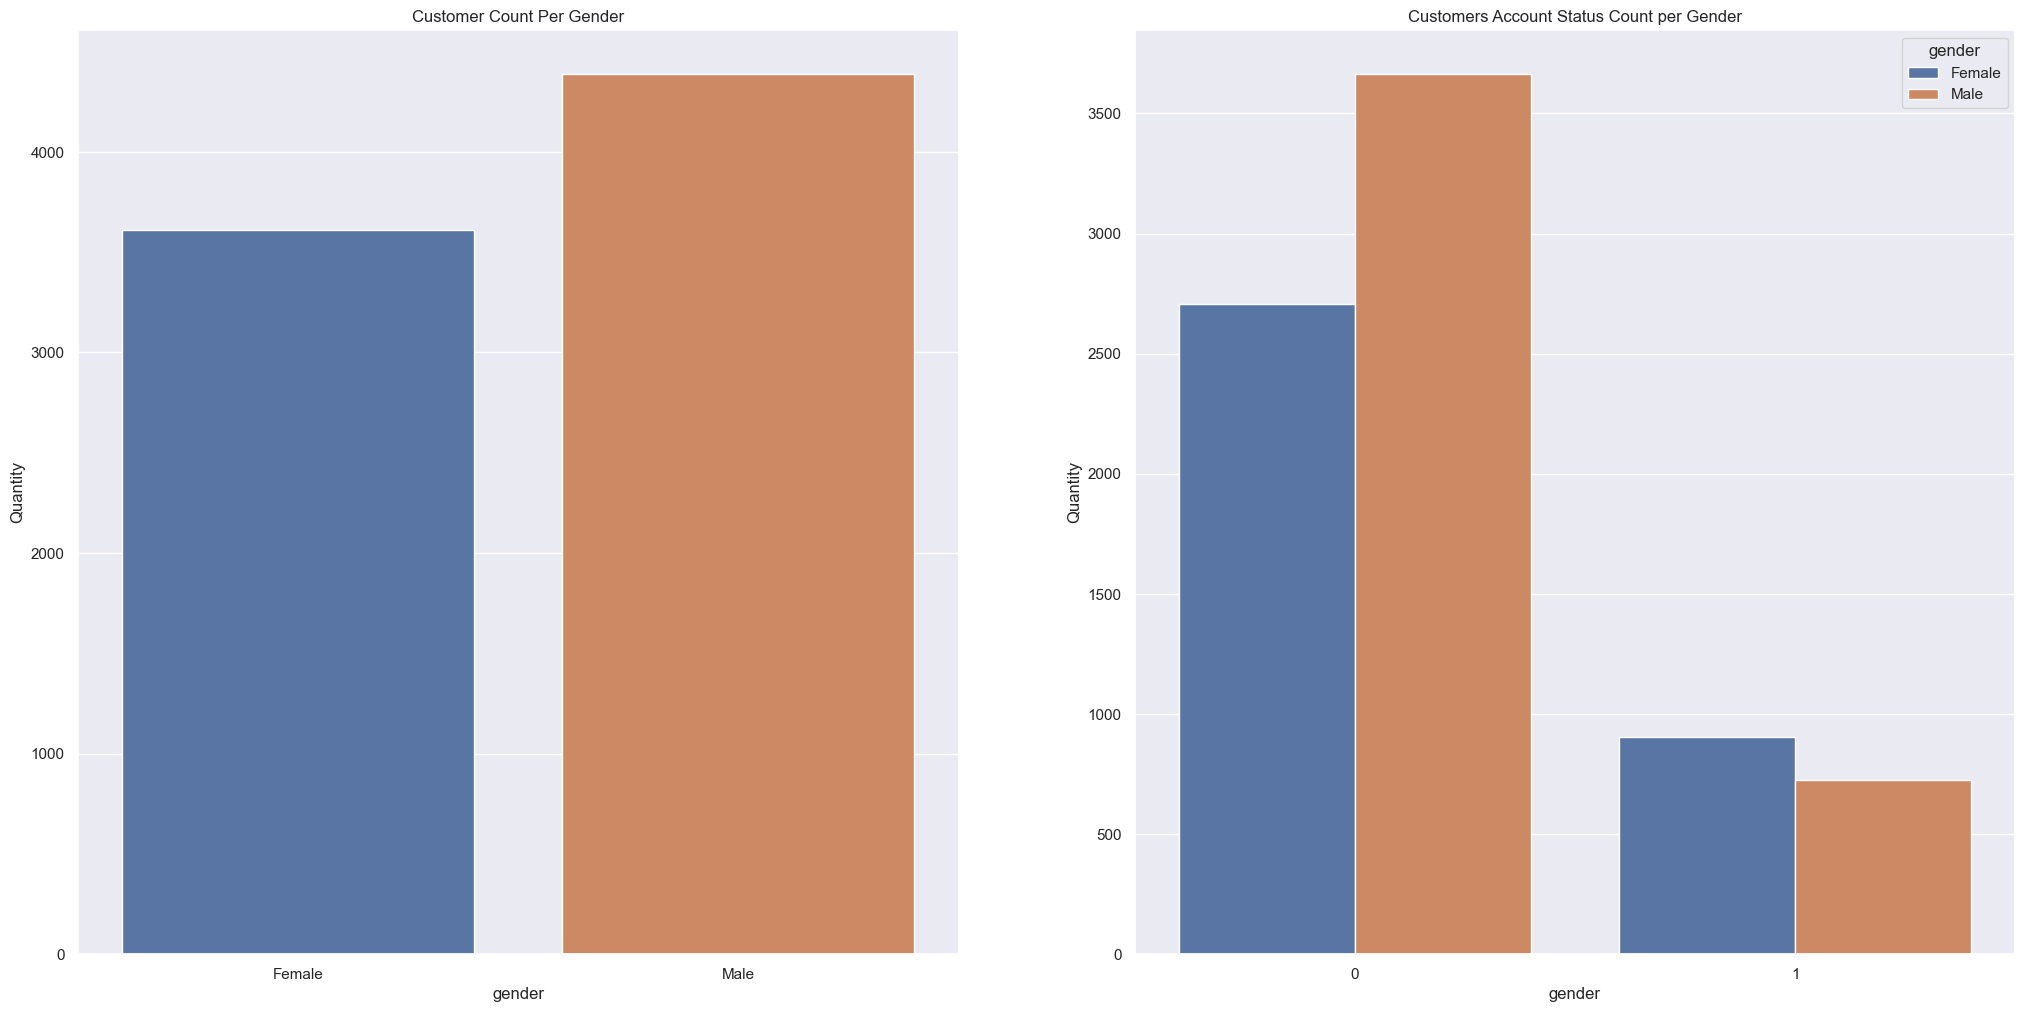

In [27]:
gender = df1.loc[ :, ['row_number', 'gender'] ].groupby(['gender']).count().reset_index()
ext_gender = df1.loc[ :, ['row_number', 'exited', 'gender'] ].groupby(['exited', 'gender']).count().reset_index()

plt.subplot(1, 2, 1)
ax = sns.barplot(x='gender', y='row_number', data=gender)
ax.set(title='Customer Count Per Gender', xlabel='gender', ylabel='Quantity');

plt.subplot(1, 2, 2)
ax = sns.barplot(x='exited', y='row_number', data=ext_gender, hue='gender');
ax.set(title='Customers Account Status Count per Gender', xlabel='gender', ylabel='Quantity');

# 2.0. Feature Engineering

In [28]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map

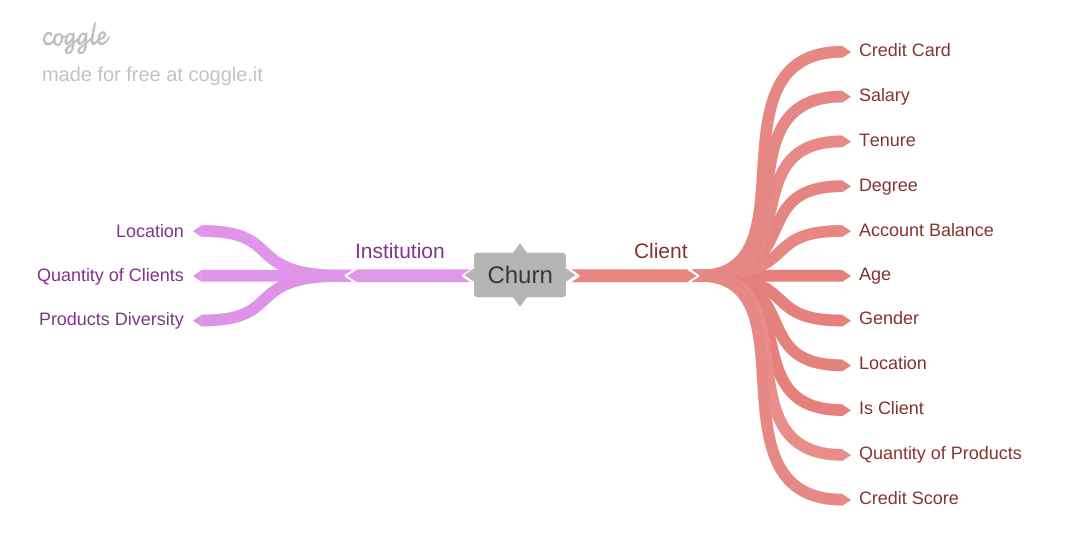

In [29]:
Image('../img/mind_map.png')

## 2.2. Hypothesis

**H1.** Clientes com 4 anos ou menos como clientes da instituição somam a maior quantidade de clientes ativos

**Possuímos a quantidade de tempo que a pessoa é cliente do banco. Coluna `tanure` e `is_active_member`**

**H2.** Clientes acima de 40 anos são os clientes que menos deixaram de ser clientes da instituição

**Possuímos a idade da pessoa. Coluna `age`**

**H3.** Clientes que compraram 2 ou mais produtos da instituição são a maioria dos clientes ativos

**Possuímos a quantidade de produtos que o cliente comprou no banco. Coluna `num_of_products` e `is_active_member`**

**H4.** Clientes com escolaridade mais alta são os clientes que mais deixaram de ser clientes.

**Não possuímos o nível de escolaridade dos clientes**

**H5.** Clientes com um Score de Crédito acima de 650 pontos são os clientes que mais deixaram de ser clientes da instituição.

**Possuímos a pontuação de crédito. Coluna `credit_score`**

**H6.** Clientes com um salário estimado acima de 99.735,00 são os clientes que mais deixaram de ser clientes.

**Possuímos o salário estimado do cliente. Coluna `estimated_salary`**

**H7.** Pessoas que possuem cartão de crédito são a maioria dos clientes que não deixaram a instituição

**Possuímos a informação se o cliente possui ou não cartão de crédito. Coluna `has_cr_card`**

**H8.** Clientes do gênero Masculino e que possuem cartão de crédito permanecem mais tempo em média como cliente da instiruição do que os clientes do gênero masculino que não possuem cartão de crédito.

**Possuímos o gênero, se o cliente possui ou não cartão de crédito e o tempo em que ele é cliente do banco. Coluna `gender`, `has_cr_card` e `tanure`, respectivamente**

**H9.** Os clientes que possuem o maior salário estimado mediano estão localizados na região da frança

**Possuímos o valor do salário estimado a região em que o cliente reside. Colunas `estimated_salary` e `region`**

**H10.** Clientes com valores de até $ 40.000,00 em suas contas compram menos produtos do banco na média comparados aos clientes que possuem um valor maior na conta.

**Possuímos possuimos o valor que o cliente possui em sua conta em a quantidade de produtos que ele comprou do banco. Colunas `balance` e `num_of_products`**

## 2.3. Chosen Hypothesis

**1.** Clientes com 4 anos ou menos como clientes da instituição somam a maior quantidade de clientes ativos

**3.** Clientes que compraram 2 ou mais produtos da instituição são a maioria dos clientes ativos

**5.** Clientes com um Score de Crédito acima de 650 pontos são os clientes que mais deixaram de ser clientes da instituição.

**7.** Pessoas que possuem cartão de crédito são a maioria dos clientes que não deixaram a instituição

**8.** Clientes do gênero Masculino e que possuem cartão de crédito permanecem mais tempo em média como cliente da instiruição do que os clientes do gênero masculino que não possuem cartão de crédito.

## 2.4. Feature Engineering

In [30]:
class CreditScoreCategoryFeature_(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X.loc[:, 'credit_score_category'] = X.apply(self.credit_score_categorization, axis=1)
        return X
    
    def credit_score_categorization(self, row):
        credit_score = row['credit_score']
        
        # Worst => 1
        # Best => 7
        if credit_score < 300:
            return 1
        elif credit_score <= 579:
            return 2
        elif credit_score <= 669:
            return 3
        elif credit_score <= 739:
            return 4
        elif credit_score < 799:
            return 5
        elif credit_score <= 850:
            return 6
        else:
            return 7

In [31]:
class EstimatedMonthlySalaryFeature_(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):    
        X.loc[:, 'estimated_monthly_salary'] = X.apply(self.estimated_monthly_salary, axis=1)
        return X
    
    def estimated_monthly_salary(self, row):
        return round(row['estimated_salary'] / 12, 2)


In [32]:
class ProductsUsedByYearFeature_(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X.loc[:, 'products_used_year'] = X.apply(self.products_used_by_year, axis=1)
        
        return X
        
    def products_used_by_year(self, row):
        if row['num_of_products'] <= 0:
            return 0
        elif row['tenure'] <= 0:
            return row['num_of_products']
        else:
            return round(row['num_of_products'] / row['tenure'], 2)


In [33]:
feature_eng_pipe = Pipeline([
    ('credit_score', utils.CreditScoreCategoryFeature()),
    ('estimated_salary', utils.EstimatedMonthlySalaryFeature()),
    ('products_used', utils.ProductsUsedByYearFeature()),
])

df_2 = feature_eng_pipe.fit_transform(df2, df2.drop('exited', axis='columns'))

cols = [
    'credit_score',
    'credit_score_category',
    'estimated_salary',
    'estimated_monthly_salary',
    'num_of_products',
    'tenure',
    'products_used_year',
]

df_2.loc[:, cols].sample(5)

,credit_score,credit_score_category,estimated_salary,estimated_monthly_salary,num_of_products,tenure,products_used_year
5974,773,5,113950.51,9495.88,1,8,0.12
1251,588,3,121504.18,10125.35,1,10,0.10
4236,492,2,39519.53,3293.29,2,4,0.50
1302,428,2,54487.43,4540.62,2,2,1.00
5788,602,3,169921.11,14160.09,2,10,0.20


# 3.0. Features Filtering

In [34]:
df3 = df2.copy()

## 3.1. Lines Filtering

## 3.2. Columns Filtering

In [35]:
class FilterColumns_(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.drop(self.columns, axis = 1) if self.columns else X


In [36]:
filter_columns_pipe = Pipeline([
    ('filter_columns', utils.FilterColumns(columns=['customer_id', 'surname', 'row_number']))
])

df3 = filter_columns_pipe.transform(df3)

# 4.0. EDA

In [37]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response

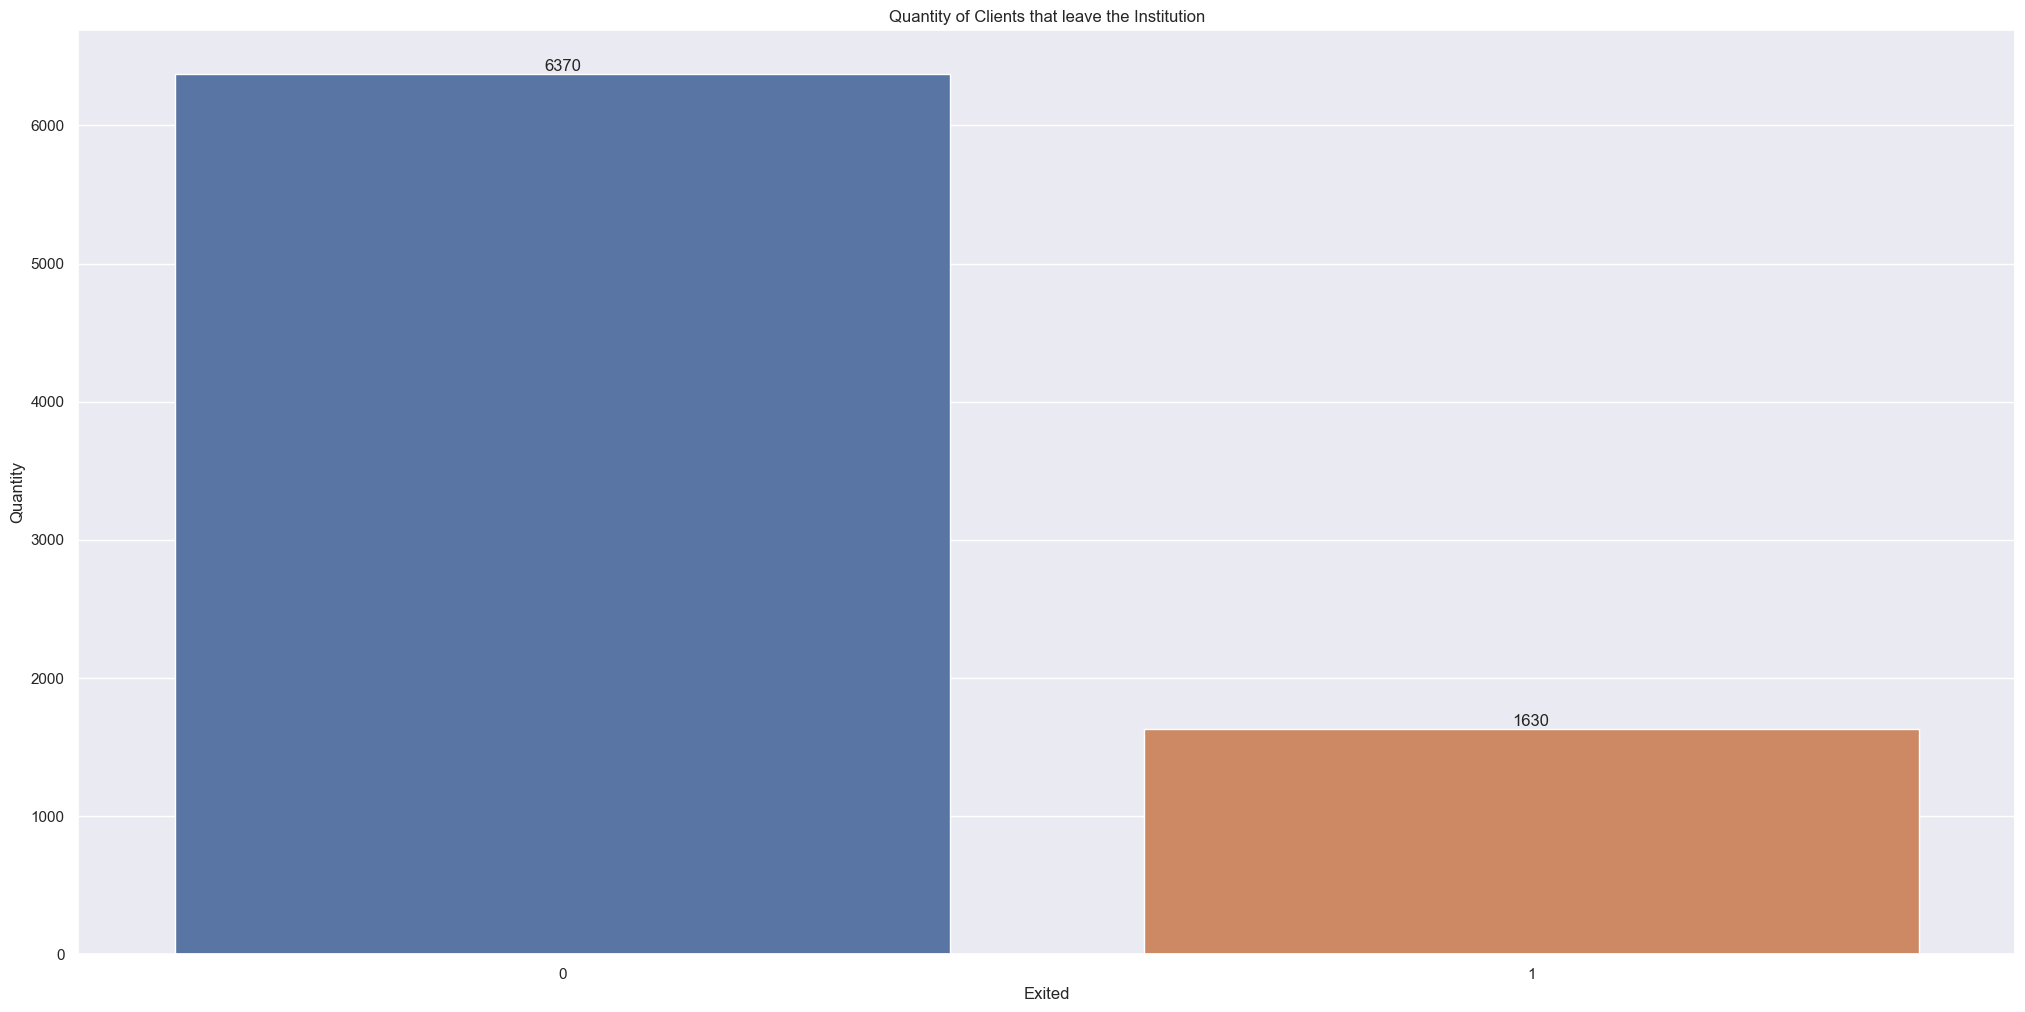

In [38]:
df_g = df4.loc[:, ['gender', 'exited']].groupby('exited').count().reset_index()

ax = sns.barplot(data=df_g, x='exited', y='gender');

ax.bar_label(ax.containers[0])

ax.set(title='Quantity of Clients that leave the Institution', xlabel='Exited', ylabel='Quantity');

### 4.1.2. Numerical Features

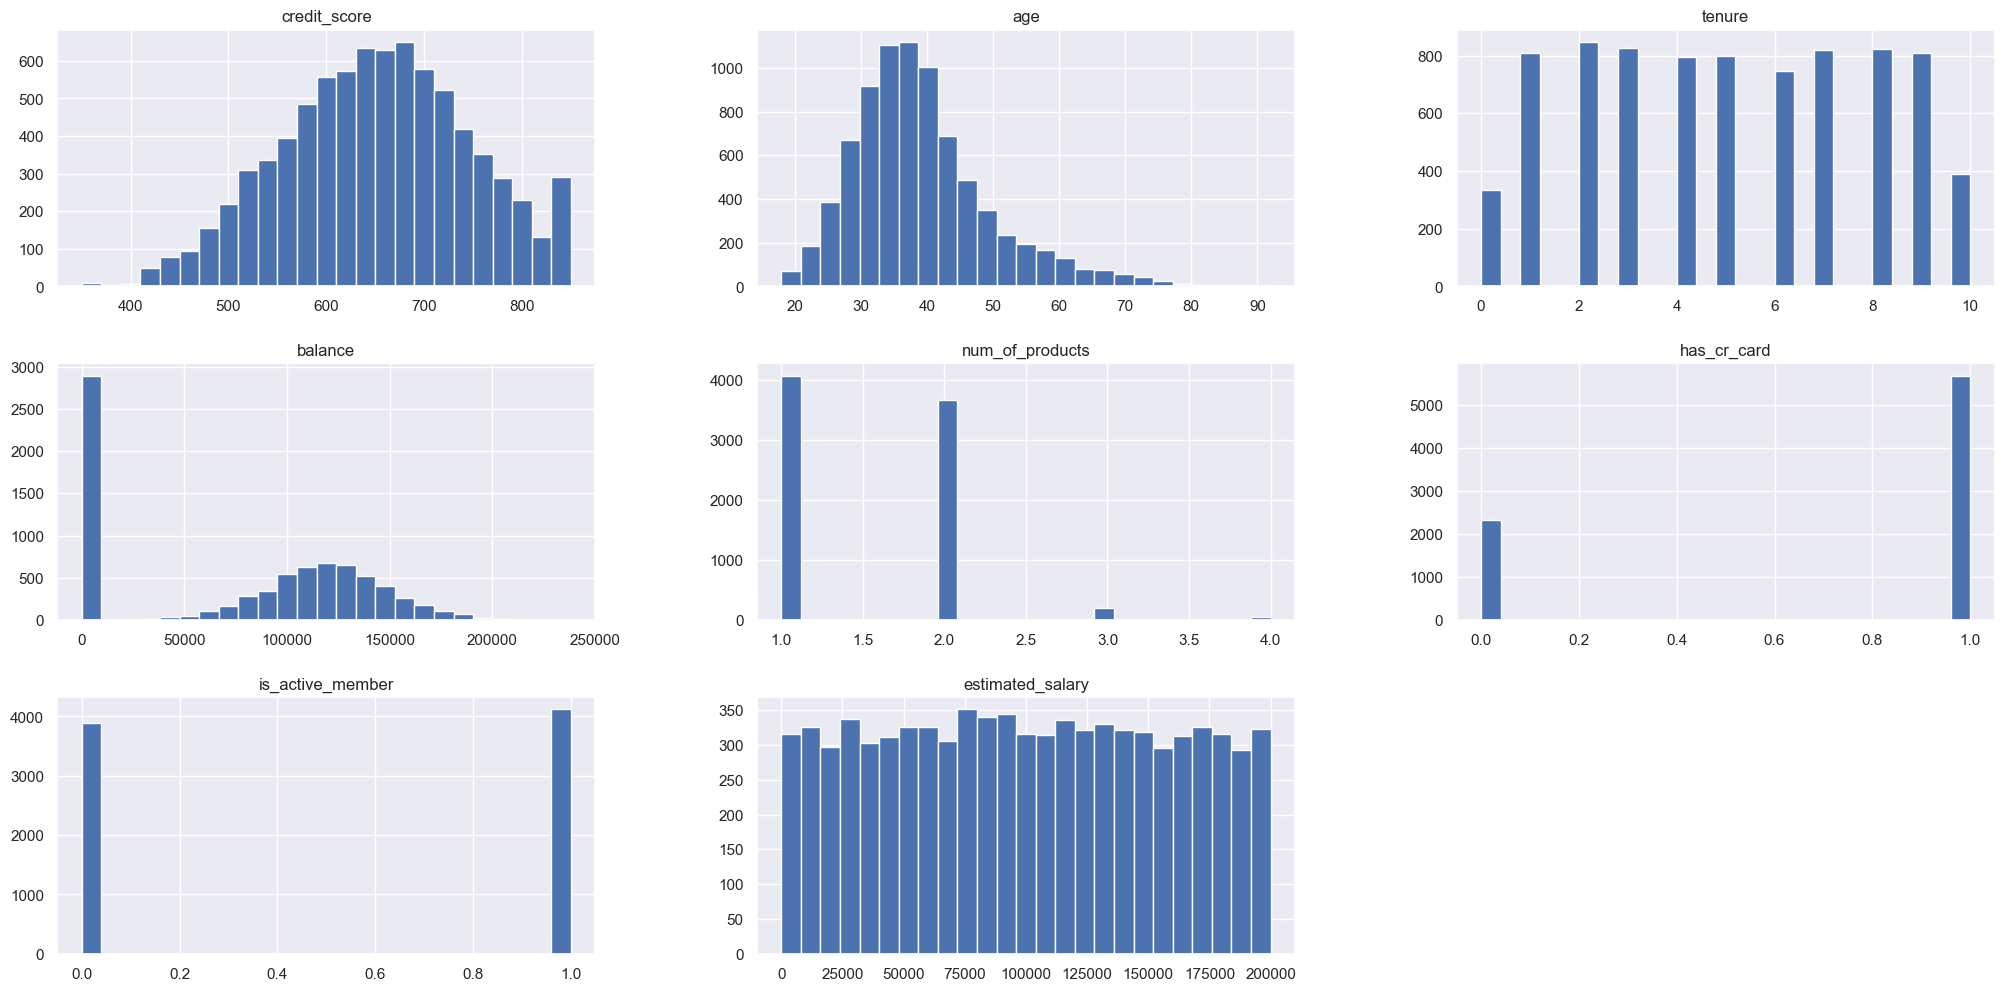

In [39]:
num_attributes.drop('customer_id', axis=1).hist(bins=25);

### 4.1.3. Categorical Features

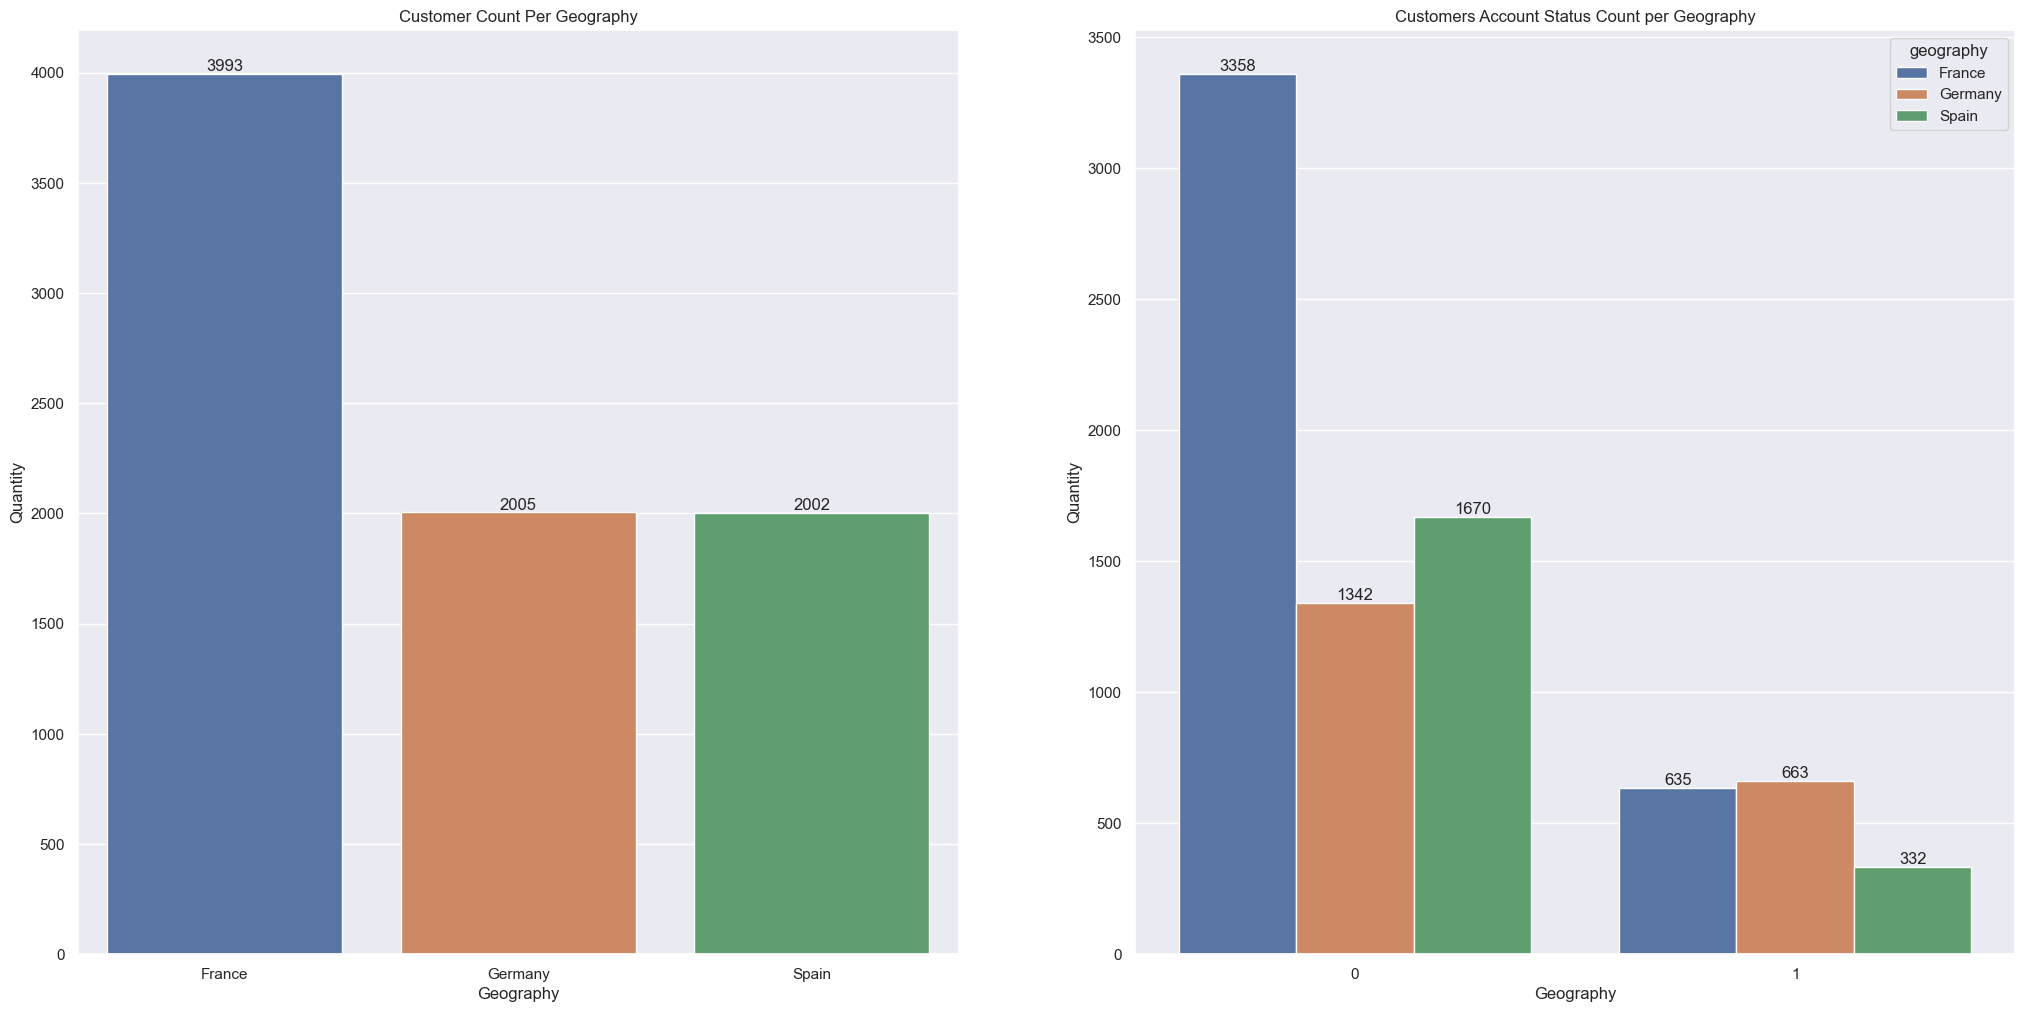

In [40]:
geography = df1.loc[ :, ['row_number', 'geography'] ].groupby(['geography']).count().reset_index()
ext_geography = df1.loc[ :, ['row_number', 'exited', 'geography'] ].groupby(['exited', 'geography']).count().reset_index()

plt.subplot(1, 2, 1)
ax = sns.barplot(x='geography', y='row_number', data=geography)
ax.bar_label(ax.containers[0])
ax.set(title='Customer Count Per Geography', xlabel='Geography', ylabel='Quantity');

plt.subplot(1, 2, 2)
ax = sns.barplot(x='exited', y='row_number', data=ext_geography, hue='geography');
for index in ax.containers:
    ax.bar_label(index, )
ax.set(title='Customers Account Status Count per Geography', xlabel='Geography', ylabel='Quantity');

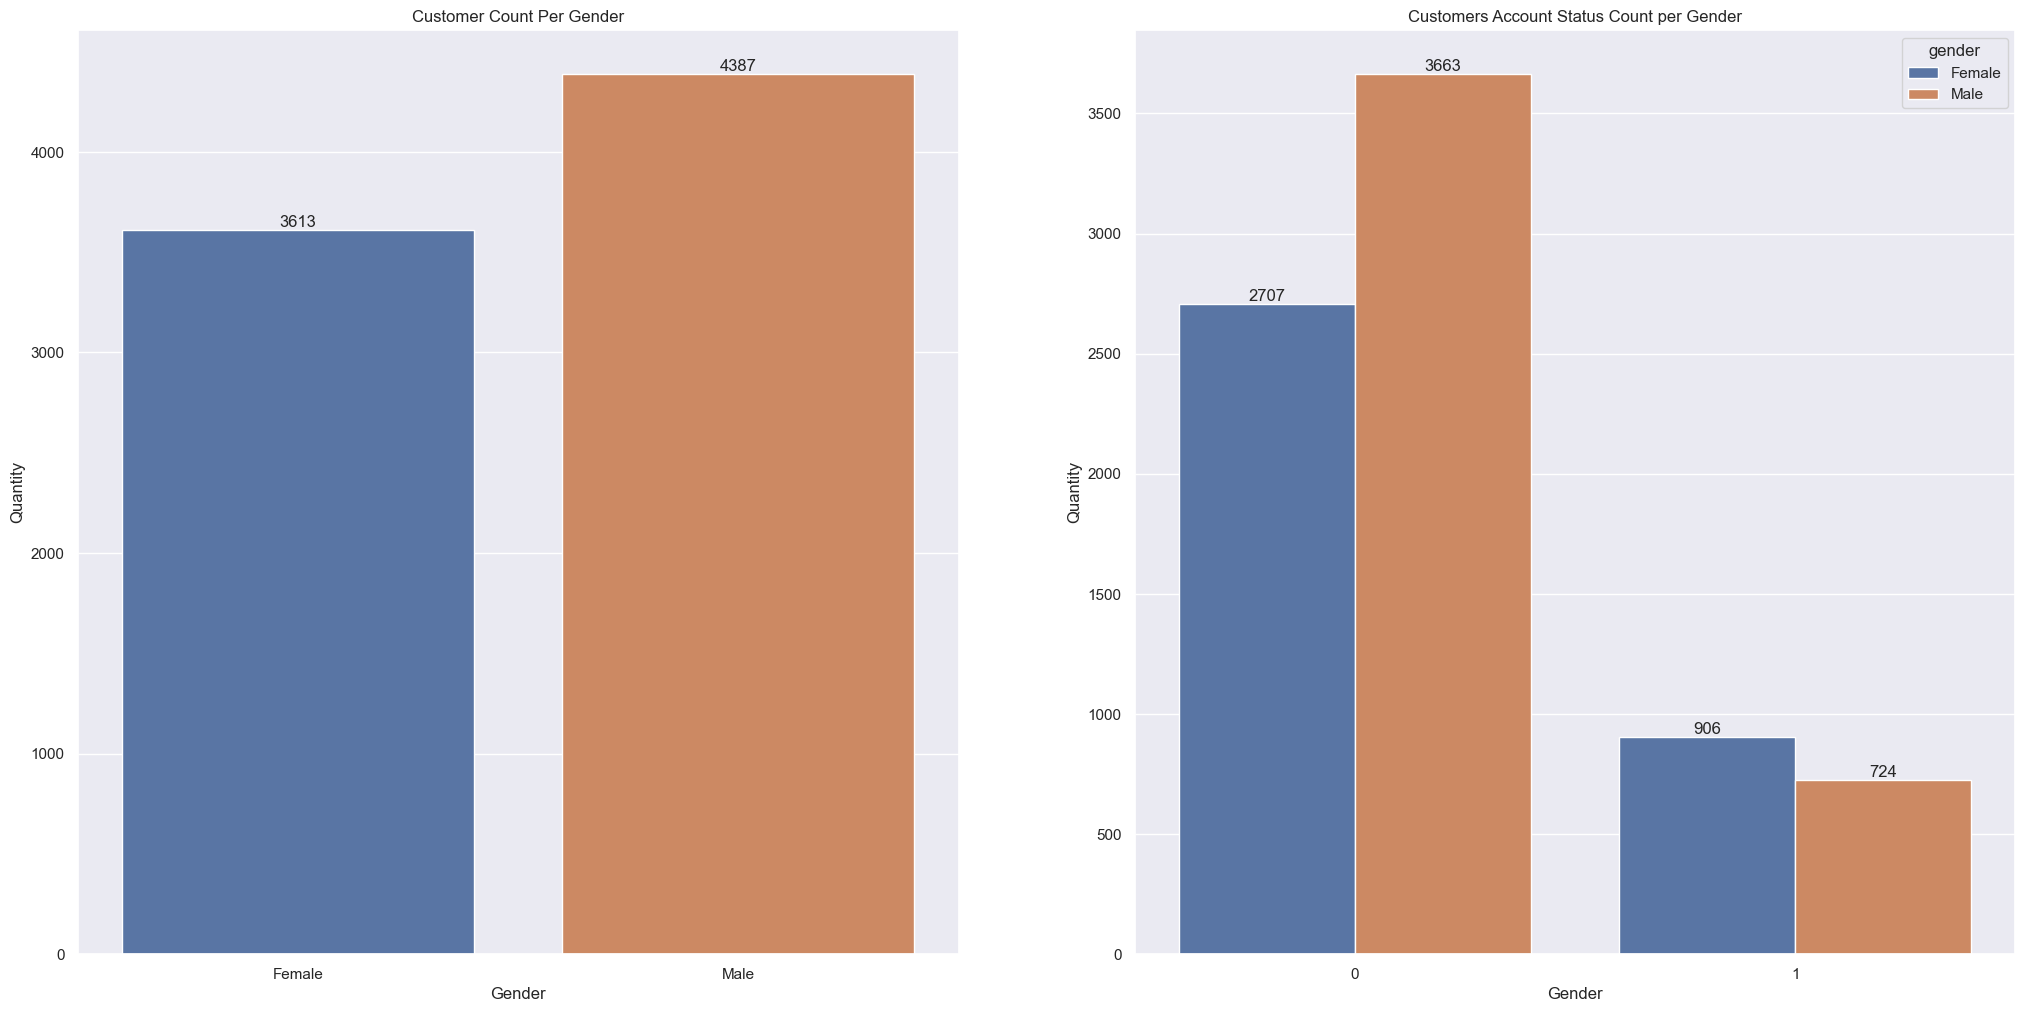

In [41]:
gender = df1.loc[ :, ['row_number', 'gender'] ].groupby(['gender']).count().reset_index()
ext_gender = df1.loc[ :, ['row_number', 'exited', 'gender'] ].groupby(['exited', 'gender']).count().reset_index()

plt.subplot(1, 2, 1)
ax = sns.barplot(x='gender', y='row_number', data=gender)
ax.bar_label(ax.containers[0])
ax.set(title='Customer Count Per Gender', xlabel='Gender', ylabel='Quantity');

plt.subplot(1, 2, 2)
ax = sns.barplot(x='exited', y='row_number', data=ext_gender, hue='gender');
for index in ax.containers:
    ax.bar_label(index, )
ax.set(title='Customers Account Status Count per Gender', xlabel='Gender', ylabel='Quantity');

## 4.2. Bivariate Analysis

**H1.** Clientes com até 4 anos de permanência na instituição, são os clientes que mais deixaram a instituição na média.

**H3.** Clientes que compraram mais produtos da instituição são os clientes que menos deixaram de ser clientes da instituição

**H5.** Clientes com um Score de Crédito acima de 650 pontos são os clientes que mais deixaram de ser clientes.

**H7.** Clientes que possuem cartão de crédito são os clientes que, na média, mais permaneceram como clientes

**H8.** Clientes do gênero Masculino e que possuem cartão de crédito permanecem mais tempo em média como cliente da instiruição do que os clientes do gênero masculino que não possuem cartão de crédito.

In [42]:
df4.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,credit_score_category,estimated_monthly_salary,products_used_year
2151,753,France,Male,57,7,0.00,1,1,0,159475.08,1,5,13289.59,0.14
8392,739,Germany,Male,32,3,102128.27,1,1,0,63981.37,1,4,5331.78,0.33
5006,755,Germany,Female,37,0,113865.23,2,1,1,117396.25,0,5,9783.02,2.00
4117,561,France,Male,37,5,0.00,2,1,0,83093.25,0,2,6924.44,0.40
7182,692,Germany,Male,49,6,110540.43,2,0,1,107472.99,0,4,8956.08,0.33


### 4.2.1. H1. Clientes com 4 anos ou menos como clientes da instituição somam a maior quantidade de clientes ativos

**FALSA** - Pessoas que são clientes há 4 anos ou menos somam a menor quantidade de clientes ativos do banco

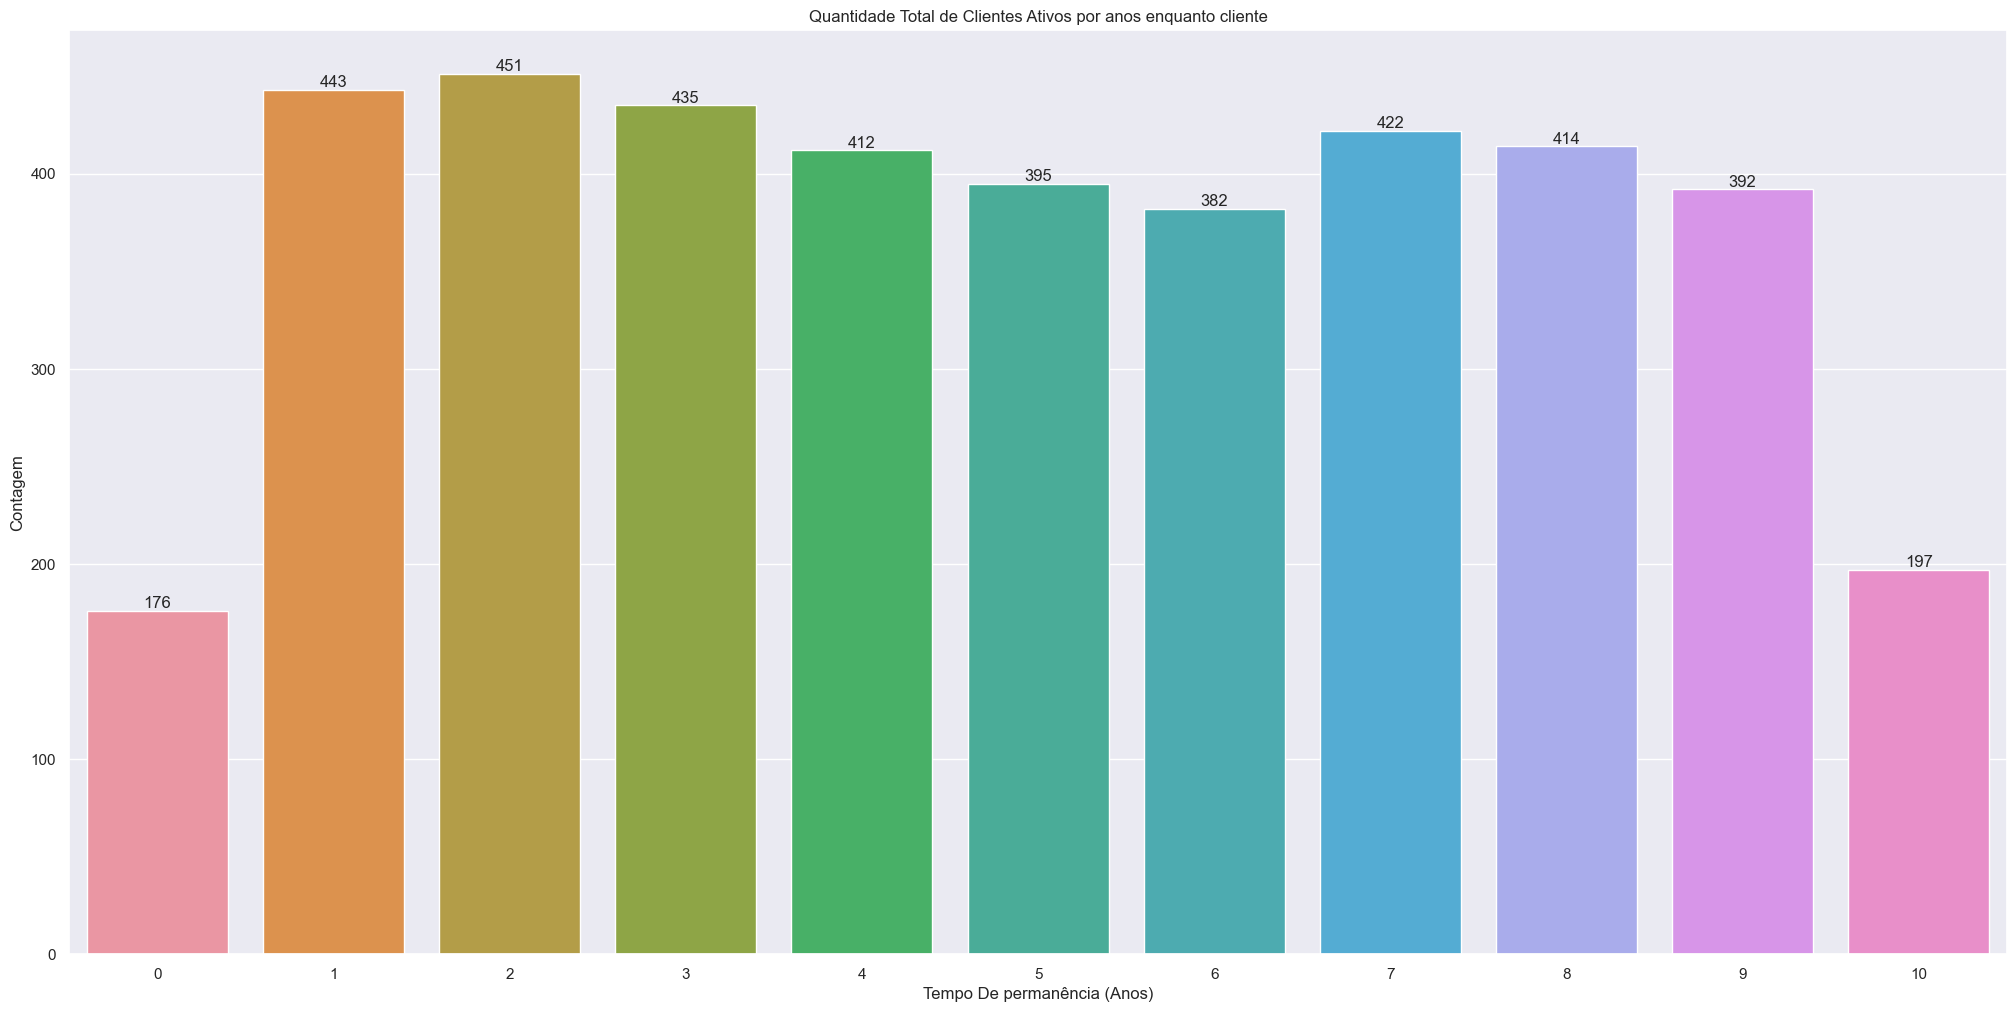

In [43]:
df_g = df4.loc[ df4['is_active_member'] == 1, ['tenure', 'age'] ].groupby('tenure').agg(
    count = pd.NamedAgg('age', 'count')
).reset_index()

ax = sns.barplot(data=df_g, x='tenure', y='count')
ax.bar_label(ax.containers[0])
ax.set(
    title='Quantidade Total de Clientes Ativos por anos enquanto cliente', 
    xlabel='Tempo De permanência (Anos)', 
    ylabel='Contagem'
);

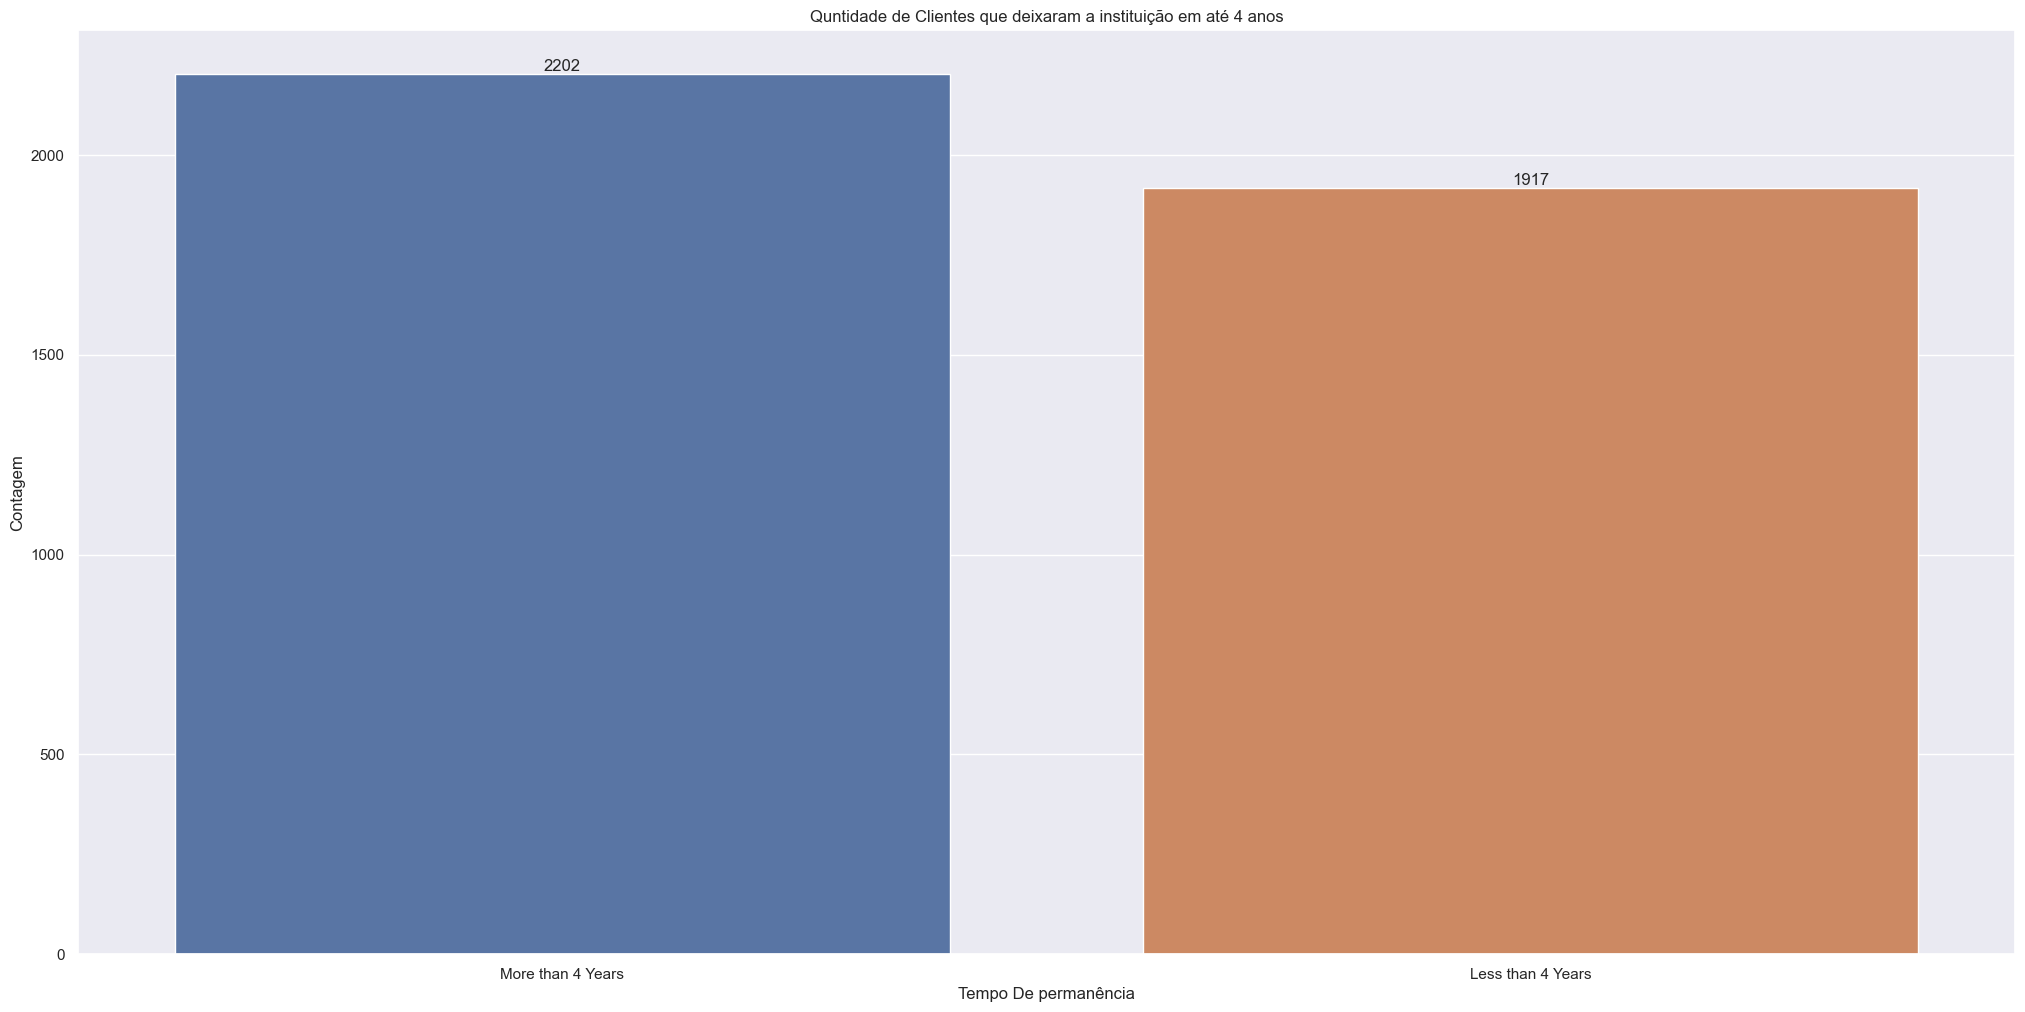

In [44]:
df_g = df4.loc[ df4['is_active_member'] == 1, ['tenure', 'age'] ].groupby('tenure').agg(
    count = pd.NamedAgg('age', 'count')
).reset_index()


lower = df_g.loc[ df_g['tenure'] <= 4, 'count'].sum()
higher = df_g.loc[ df_g['tenure'] > 4, 'count'].sum()

df_aux = pd.DataFrame({
    'tenure': ['More than 4 Years', 'Less than 4 Years'],
    'count': [higher, lower]
})

ax = sns.barplot(data=df_aux, x='tenure', y='count')
ax.bar_label(ax.containers[0])
ax.set(title='Quntidade de Clientes que deixaram a instituição em até 4 anos', xlabel='Tempo De permanência', ylabel='Contagem');

### 4.2.2. H3. Clientes que compraram 2 ou mais produtos da instituição são a maioria dos clientes ativos

**VERDADEIRA** - Clientes que compraram 2 produtos ou mais são a maioria dos clientes ativos do banco

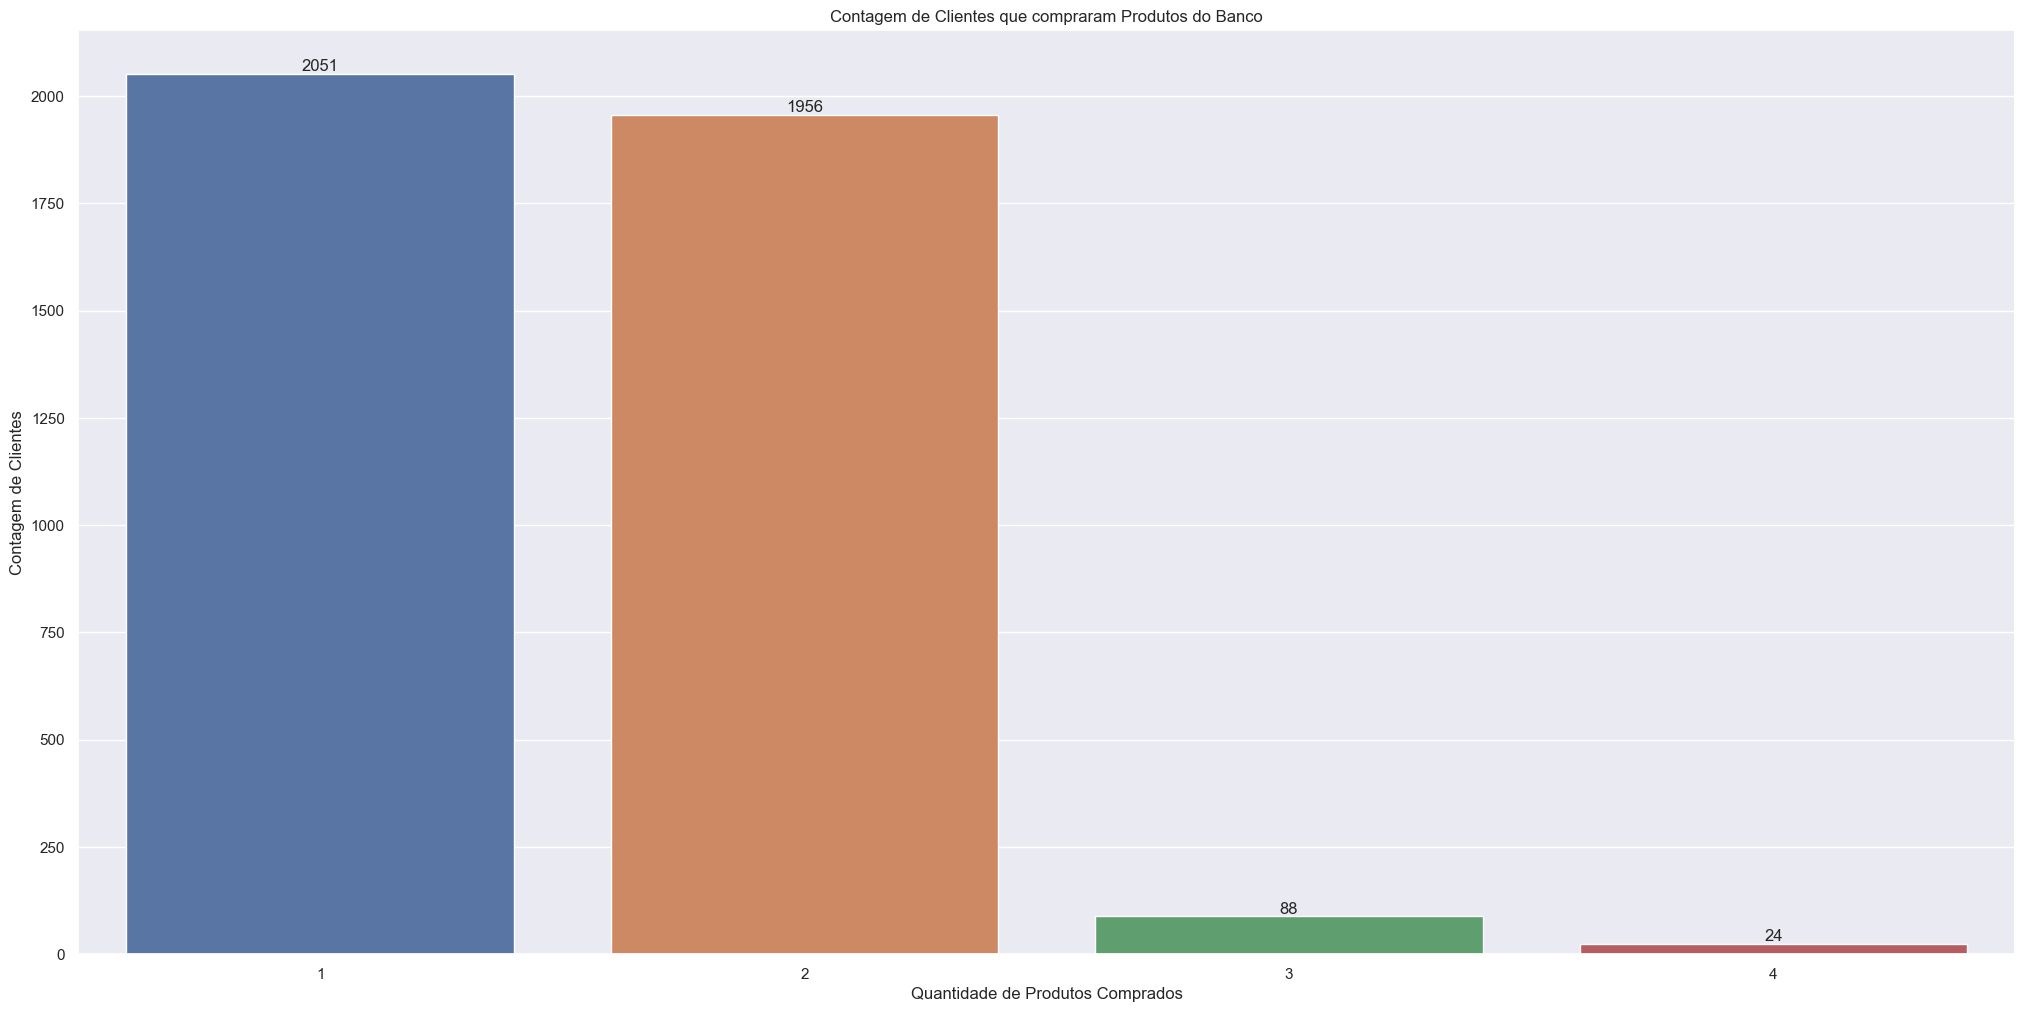

In [45]:
df_g = df4.loc[ df4['is_active_member'] == 1, ['num_of_products', 'age'] ].groupby('num_of_products').agg(
    count = pd.NamedAgg('age', 'count')
).reset_index()

ax = sns.barplot(data=df_g, x='num_of_products', y='count')
ax.bar_label(ax.containers[0])
ax.set(
    title='Contagem de Clientes que compraram Produtos do Banco', 
    xlabel='Quantidade de Produtos Comprados', 
    ylabel='Contagem de Clientes'
);

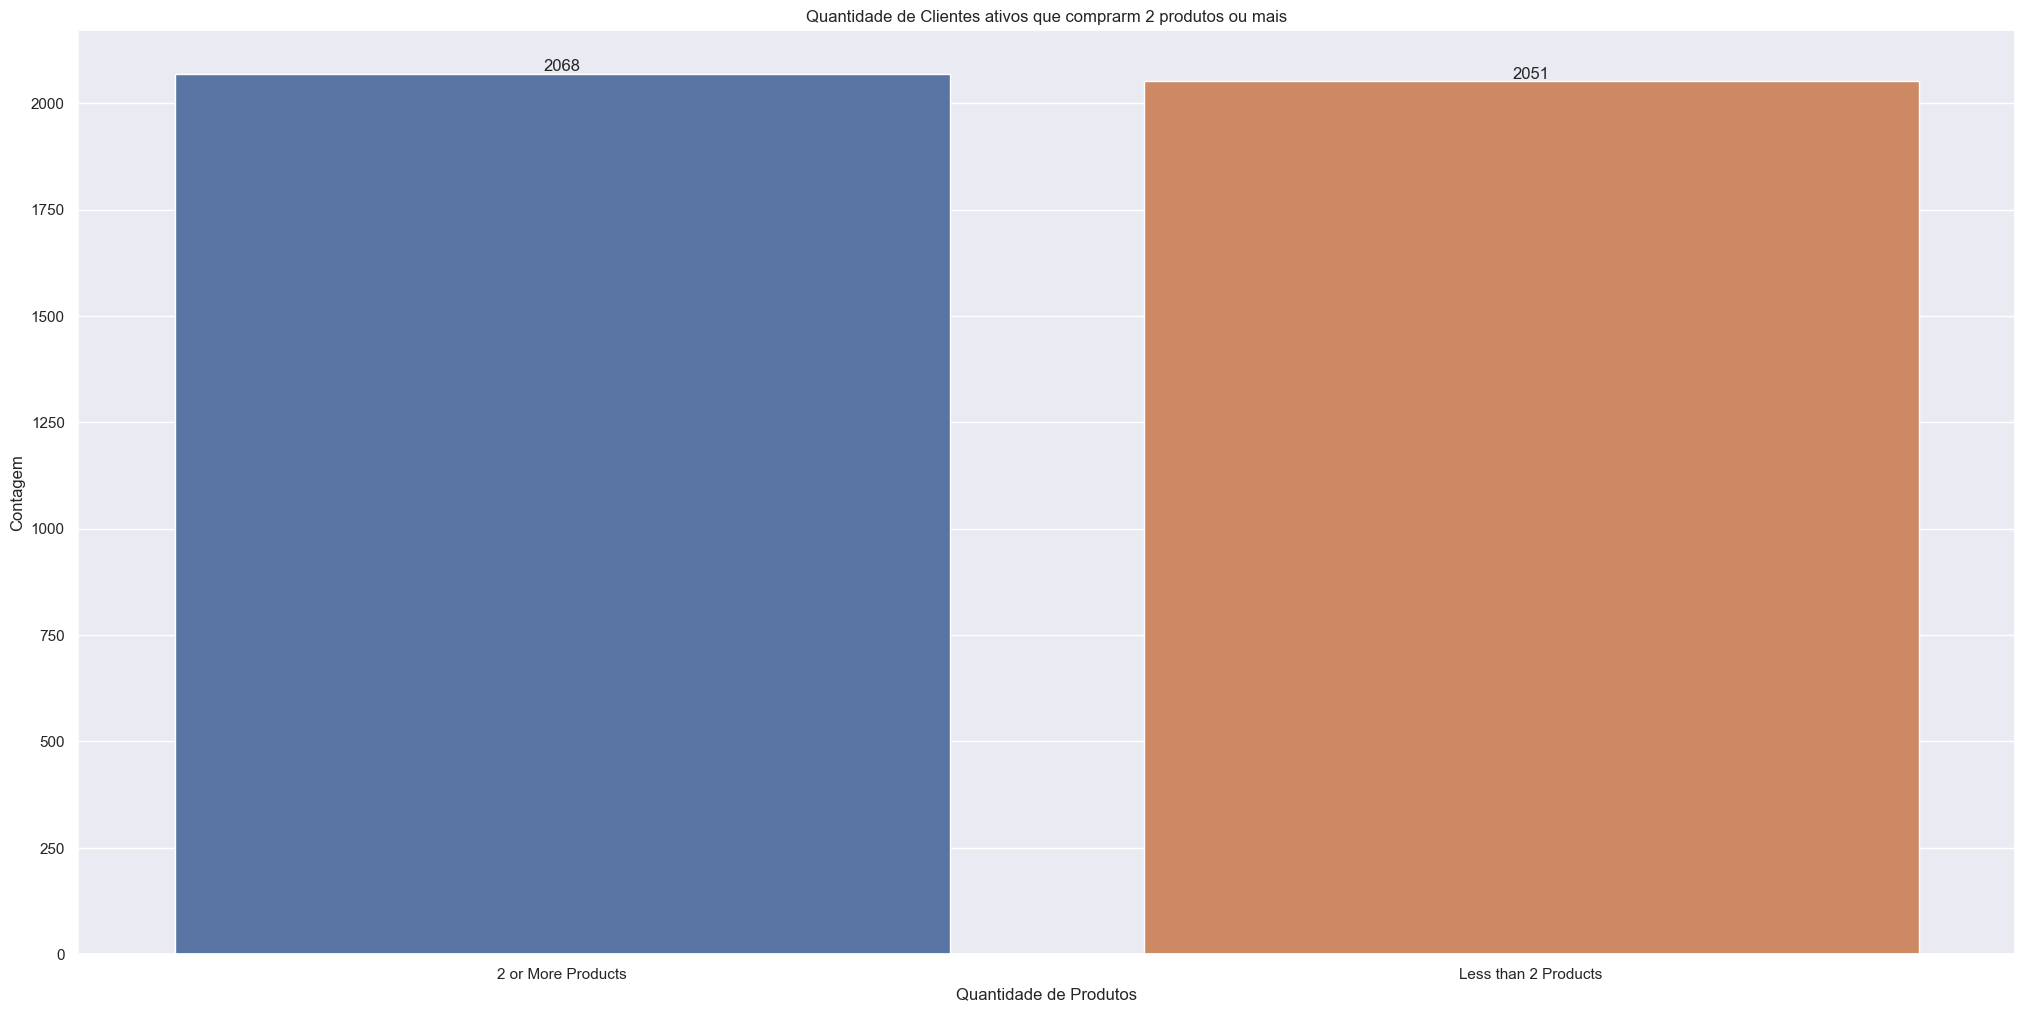

In [46]:
df_g = df4.loc[ (df4['is_active_member'] == 1), ['num_of_products', 'age'] ].groupby('num_of_products').agg(
    count = pd.NamedAgg('age', 'count')
).reset_index()


lower = df_g.loc[ df_g['num_of_products'] <= 1, 'count'].sum()
higher = df_g.loc[ df_g['num_of_products'] > 1, 'count'].sum()

df_aux = pd.DataFrame({
    'num_of_products': ['2 or More Products', 'Less than 2 Products'],
    'count': [higher, lower]
})

ax = sns.barplot(data=df_aux, x='num_of_products', y='count')
ax.bar_label(ax.containers[0])
ax.set(
    title='Quantidade de Clientes ativos que comprarm 2 produtos ou mais', 
    xlabel='Quantidade de Produtos', 
    ylabel='Contagem'
);

### 4.2.3. H5. Clientes com um Score de Crédito acima de 650 pontos são os clientes que mais deixaram de ser clientes da instituição. 

**FALSA** - Clientes com Score de crédito acima de 650 pontos são os clientes que mais PERMANECERAM como clientes da instituição

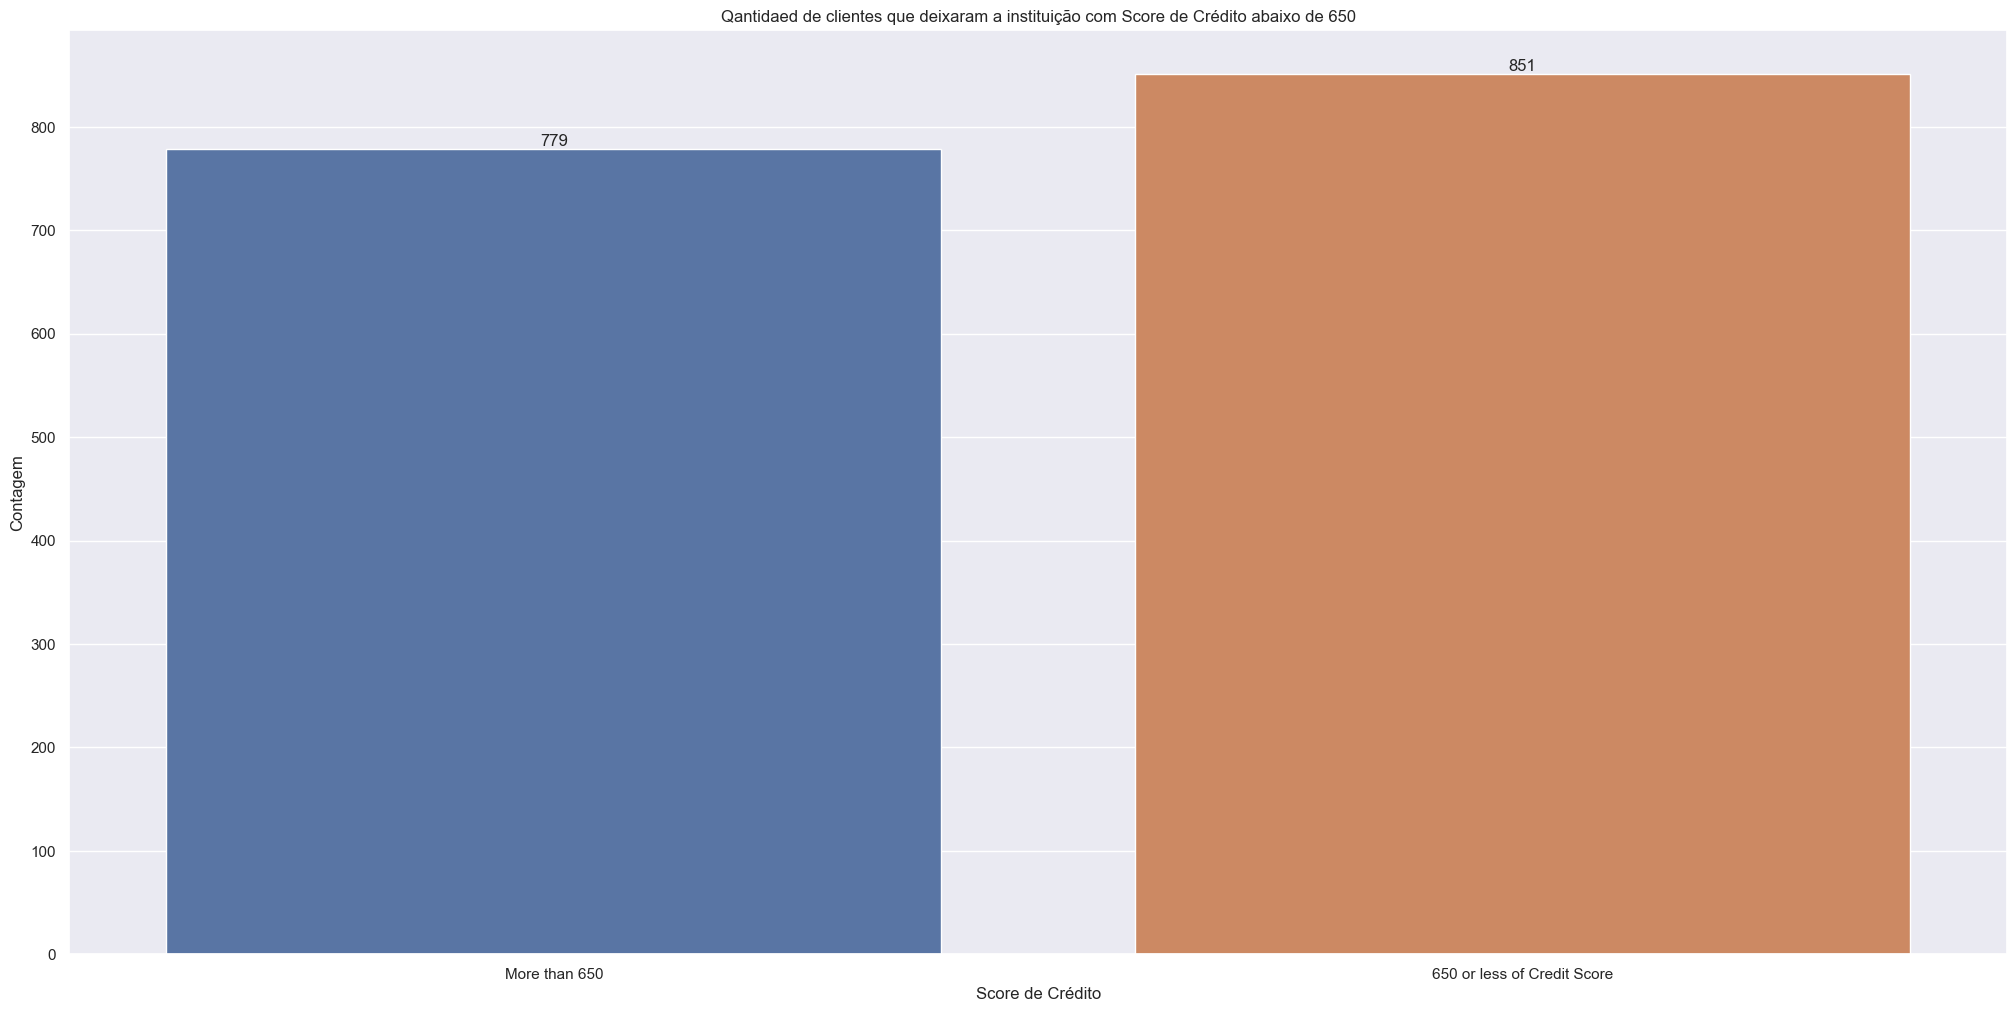

In [47]:
df_g = df4.loc[ (df4['exited'] == 1), ['credit_score', 'age'] ].groupby('credit_score').agg(
    count = pd.NamedAgg('age', 'count')
).reset_index()


lower = df_g.loc[ df_g['credit_score'] <= 650, 'count'].sum()
higher = df_g.loc[ df_g['credit_score'] > 650, 'count'].sum()

df_aux = pd.DataFrame({
    'credit_score': ['More than 650', '650 or less of Credit Score'],
    'count': [higher, lower]
})

ax = sns.barplot(data=df_aux, x='credit_score', y='count')
ax.bar_label(ax.containers[0])
ax.set(
    title='Qantidaed de clientes que deixaram a instituição com Score de Crédito abaixo de 650', 
    xlabel='Score de Crédito', 
    ylabel='Contagem'
);

### 4.2.4. H7. Pessoas que possuem cartão de crédito são a maioria dos clientes que não deixaram a instituição

**FALSA** - Clientes que não possuem cartão de crédito são a maioria dos clientes que não deixaram a instituição

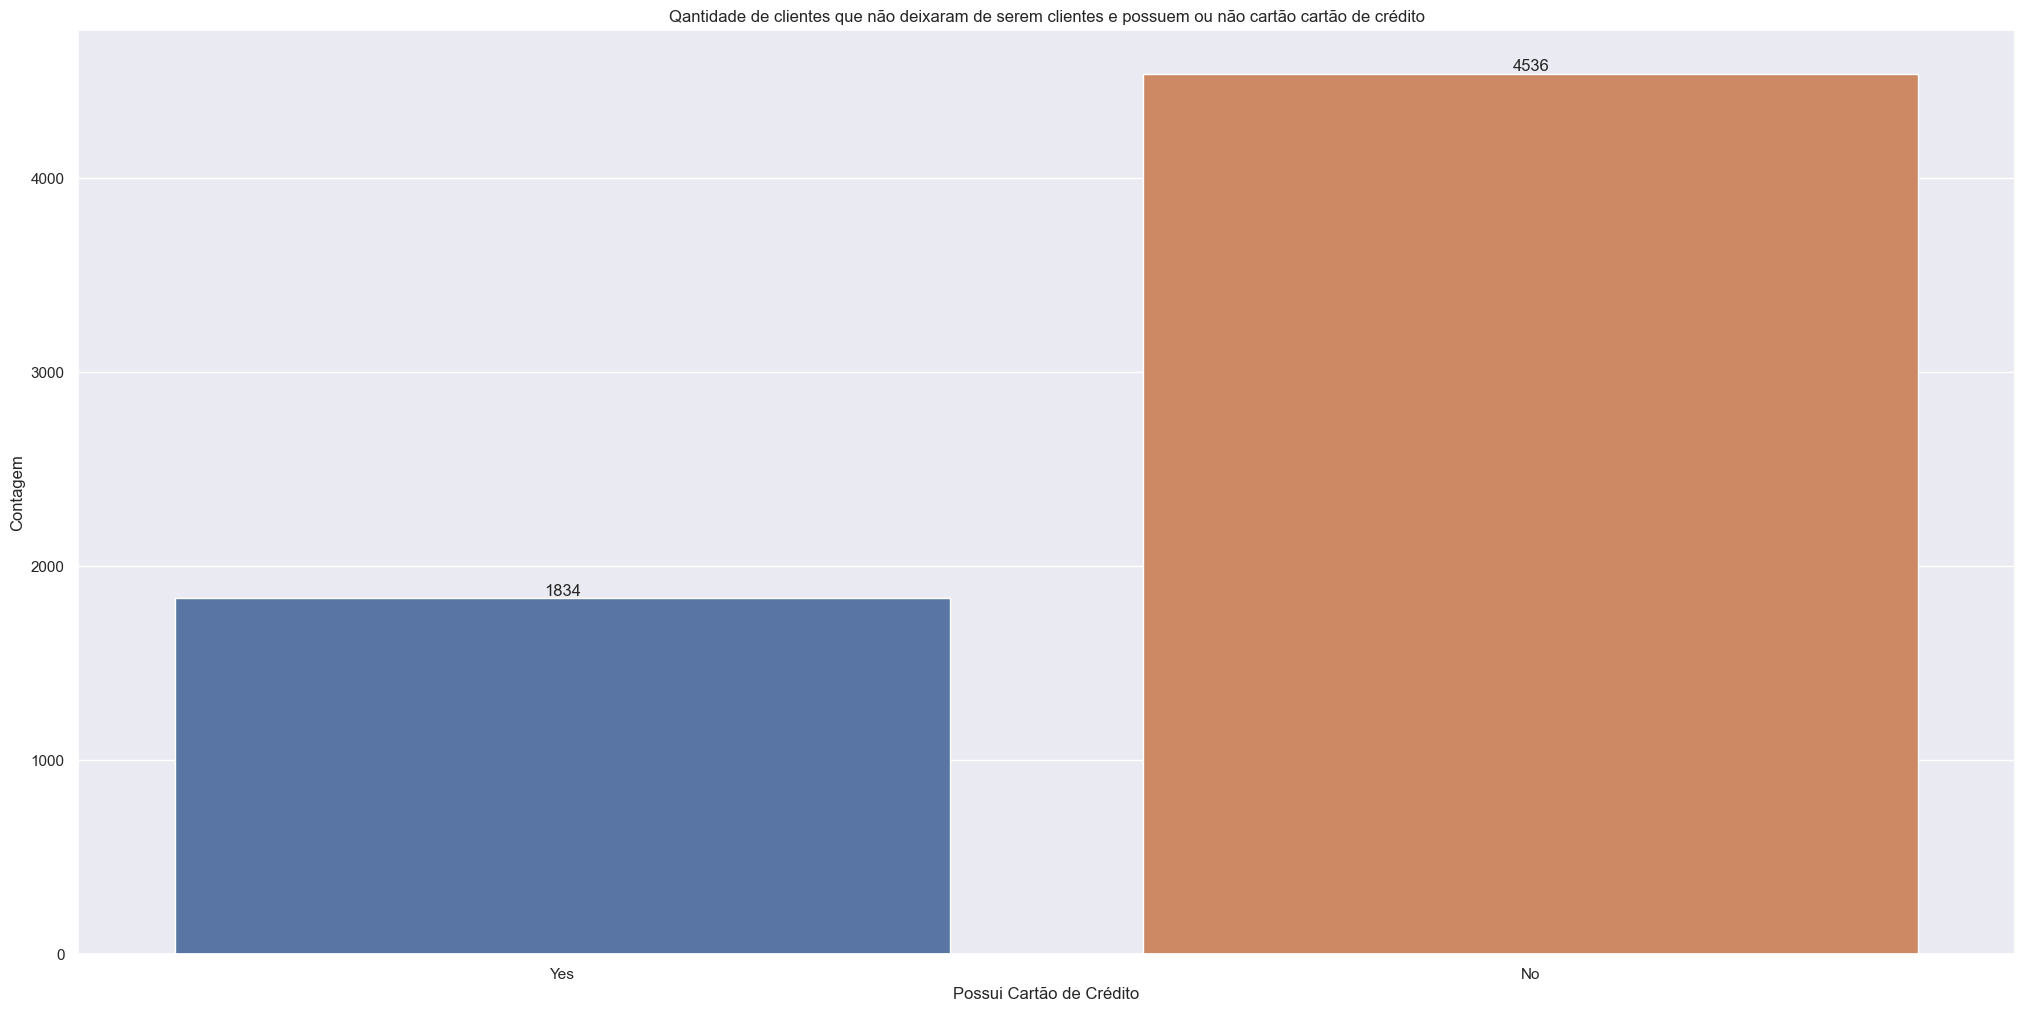

In [48]:
df_g = df4.loc[ df4['exited'] == 0, ['has_cr_card', 'age'] ].groupby('has_cr_card').agg(
    count = pd.NamedAgg('age', 'count')
).reset_index()


no = df_g.loc[ df_g['has_cr_card'] == 1, 'count'].sum()
yes = df_g.loc[ df_g['has_cr_card'] == 0, 'count'].sum()

df_aux = pd.DataFrame({
    'has_cr_card': ['Yes', 'No'],
    'count': [yes, no]
})

ax = sns.barplot(data=df_aux, x='has_cr_card', y='count')
ax.bar_label(ax.containers[0])
ax.set(
    title='Qantidade de clientes que não deixaram de serem clientes e possuem ou não cartão cartão de crédito',
    xlabel='Possui Cartão de Crédito', 
    ylabel='Contagem'
);

### 4.2.5. H8. Clientes do gênero Masculino e que possuem cartão de crédito compraram mais produtos do banco em comparação com clientes do gênero Feminino que possuem cartão de crédito.

**VERDADEIRA** - Clientes do gênero Masculino que possuem cartão de crédito compraram mais produtos do banco quando comparados com clientes do gênero Feminino que possuem cartão de crédito.

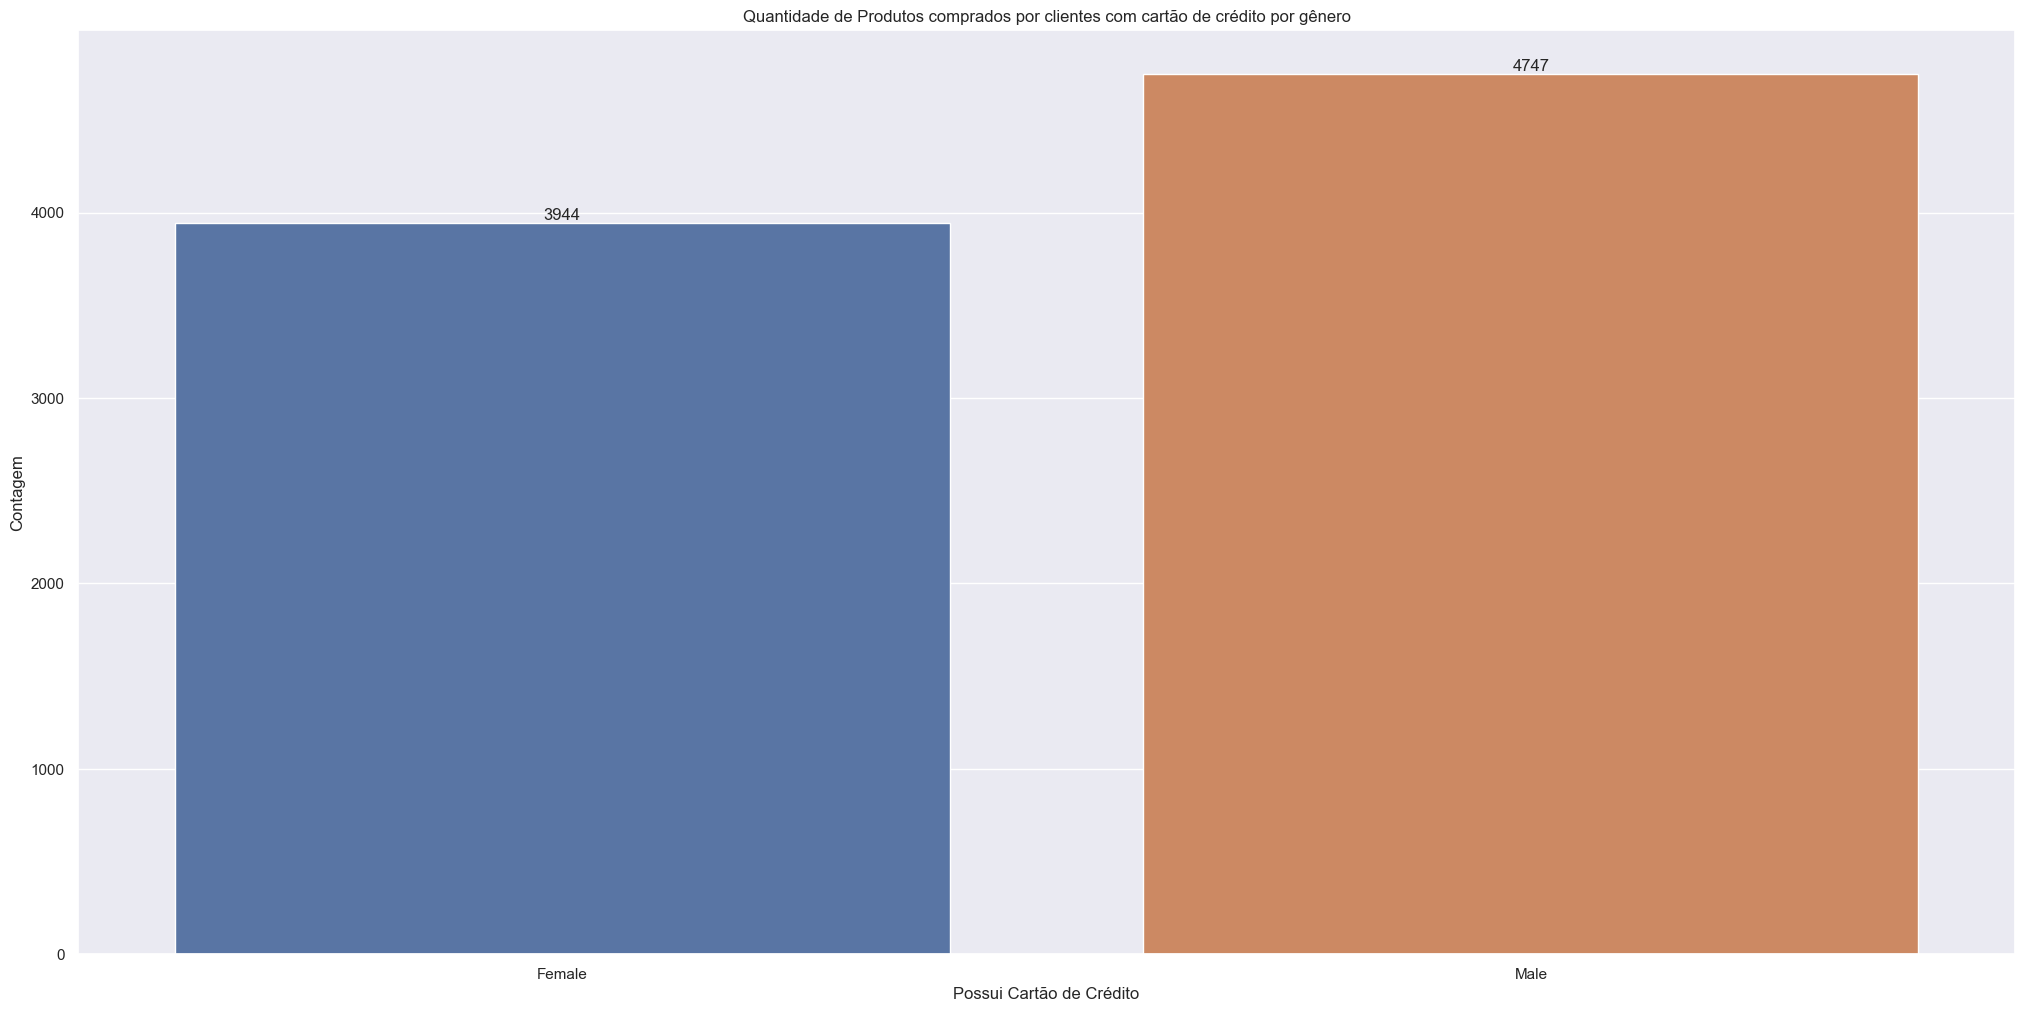

In [49]:
df_g = df4.loc[ df4['has_cr_card'] == 1, ['gender', 'num_of_products'] ].groupby('gender').agg(
    sum = pd.NamedAgg('num_of_products', 'sum'),
).reset_index()

ax = sns.barplot(data=df_g, x='gender', y='sum')
ax.bar_label(ax.containers[0])
ax.set(
    title='Quantidade de Produtos comprados por clientes com cartão de crédito por gênero',
    xlabel='Possui Cartão de Crédito', 
    ylabel='Contagem'
);

### 4.2.6. Hypothesis Analysis

| Hypothesis | Conclusion | Relevance |
| :--------- | :--------- | :-------- |
| H1 | FALSE | Low |
| H2 | - | - |
| H3 | TRUE | Low |
| H4 | - | - |
| H5 | FALSE | High |
| H6 | - | - |
| H7 | FALSE | High |
| H8 | TRUE | Low |
| H9 | - | - |
| H10 | - | - |

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Features

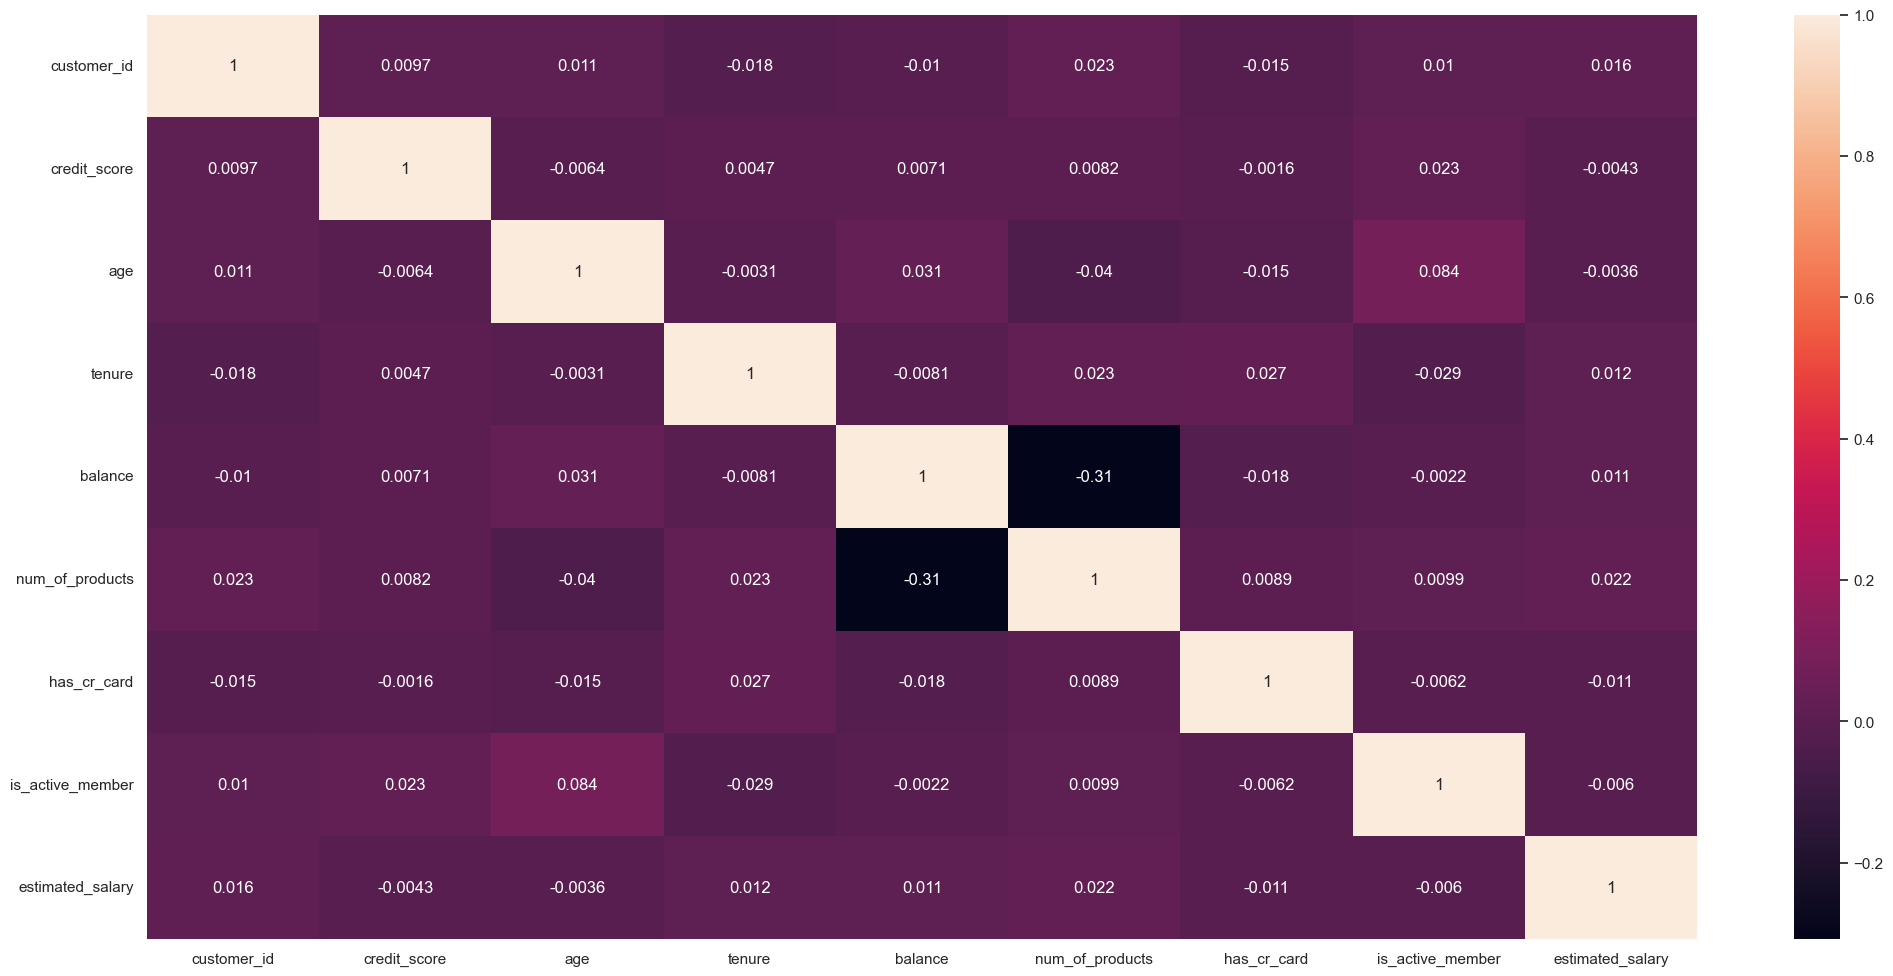

In [50]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Features

In [51]:
df4.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,credit_score_category,estimated_monthly_salary,products_used_year
2151,753,France,Male,57,7,0.00,1,1,0,159475.08,1,5,13289.59,0.14
8392,739,Germany,Male,32,3,102128.27,1,1,0,63981.37,1,4,5331.78,0.33
5006,755,Germany,Female,37,0,113865.23,2,1,1,117396.25,0,5,9783.02,2.00
4117,561,France,Male,37,5,0.00,2,1,0,83093.25,0,2,6924.44,0.40
7182,692,Germany,Male,49,6,110540.43,2,0,1,107472.99,0,4,8956.08,0.33


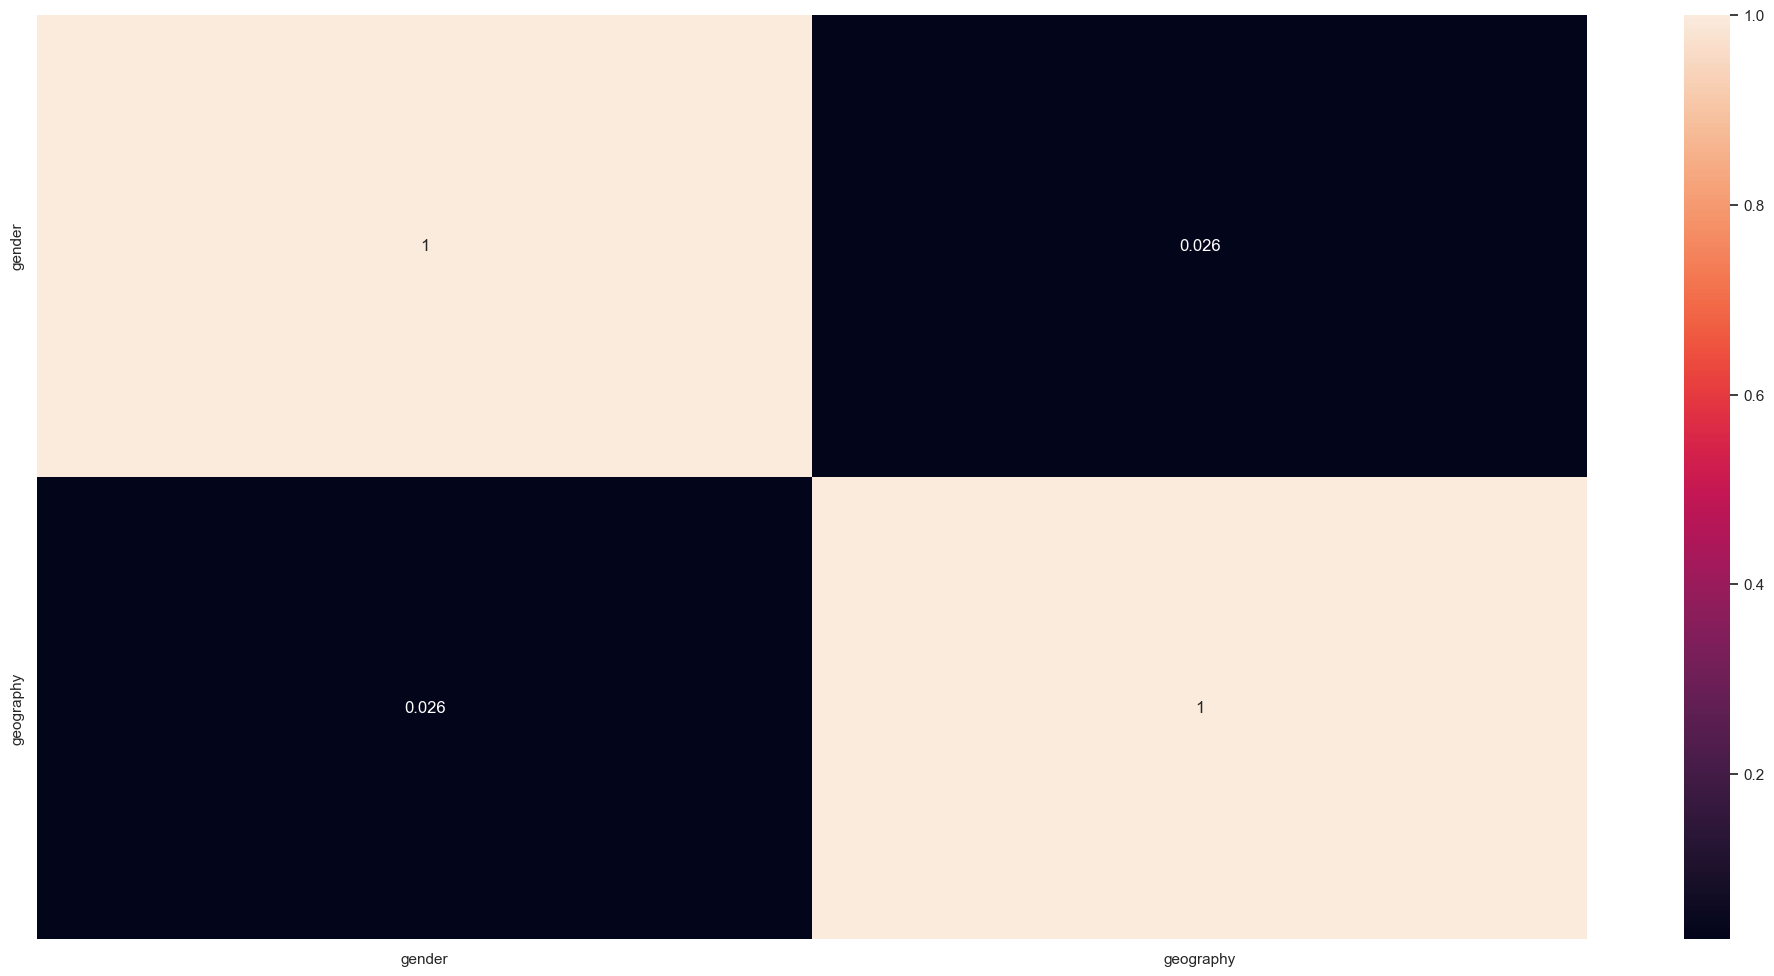

In [52]:
# Selecionando somente Dados Categóricos
cat = df4.loc[:, ['gender', 'geography']]

# Calcula Cramer V
a1 = cramer_v(cat['gender'], cat['gender'])
a2 = cramer_v(cat['gender'], cat['geography'])

a3 = cramer_v(cat['geography'], cat['gender'])
a4 = cramer_v(cat['geography'], cat['geography'])

# Dataset Final
df = pd.DataFrame({
    'gender': [a1, a2],
    'geography': [a3, a4],
})

df = df.set_index(df.columns)

# Mapa de Calor para verificar a correlação entre as variáveis categóricas
sns.heatmap(df, annot=True);

# 5.0. Data Preparation

In [53]:
df5 = df4.copy()

## 5.1. Normalization

### 5.1.1. Rescaling

In [54]:
NUMERICAL = df5.select_dtypes(include=['int64', 'float64']).drop('exited', axis=1).columns

numerical_pipe = Pipeline([
    ('scaler', StandardScaler())
])

## 5.2. Transformations

### 5.2.1. Encodings

In [55]:
CATEGORICAL = df5.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).columns
print(f"Categorical features: {CATEGORICAL}")

categorical_pipe = Pipeline([
    ('encoder', OneHotEncoder(drop='first', sparse=False))
])

Categorical features: Index(['geography', 'gender'], dtype='object')


## 5.4. Preprocessing Pipeline

In [56]:
data_preparation = ColumnTransformer(
    transformers=[
        ('num', numerical_pipe, NUMERICAL),
        ('cat', categorical_pipe, CATEGORICAL),
    ]
)

# 6.0. Feature Selection

In [144]:
df6 = df5.copy()

## 6.1. Random Forest Feature Importance

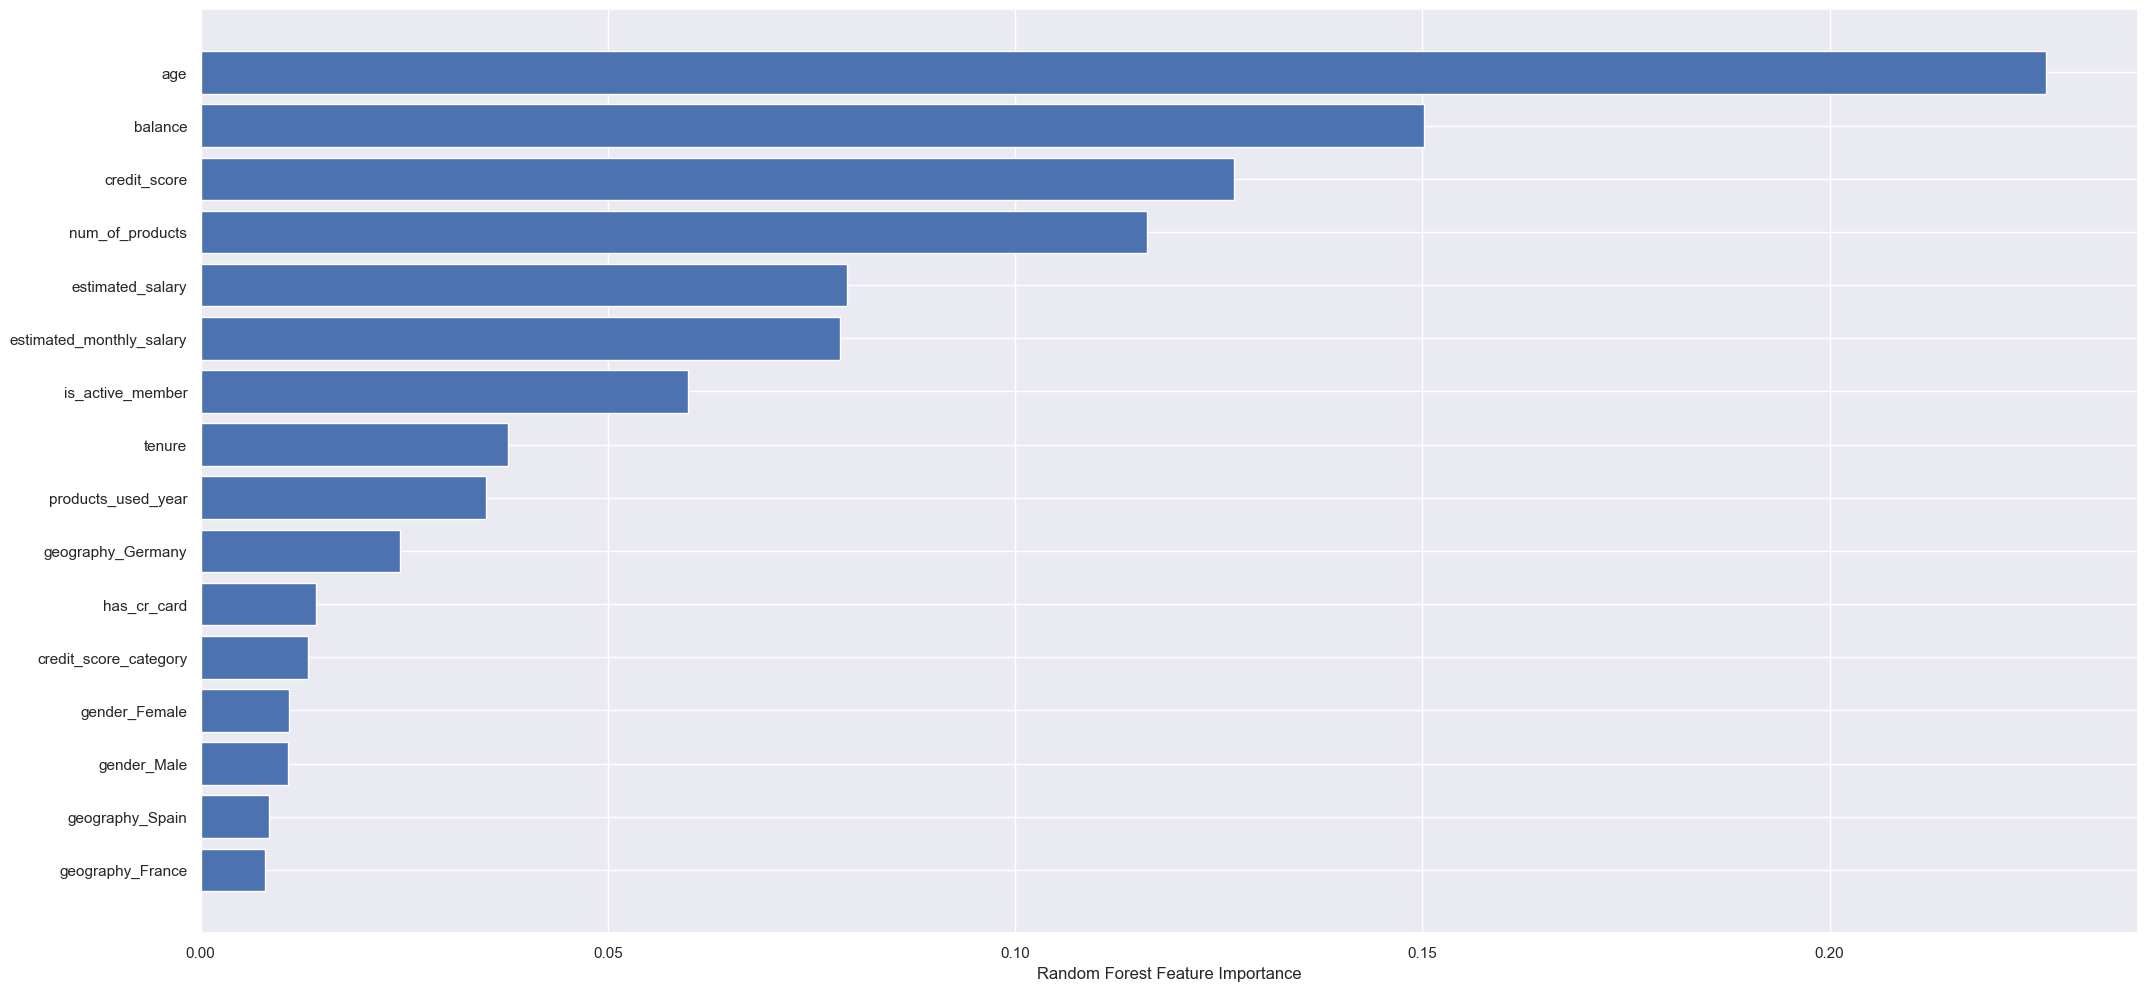

In [174]:
# Define Scaler and Random Forest Regressor
ss = StandardScaler()
rf = RandomForestRegressor(n_estimators=100, random_state=SEED, n_jobs=-1)

# Apply Scaler and Pre Processing to Dataframe
df6_num = pd.DataFrame(ss.fit_transform(df6[NUMERICAL].copy()), columns=NUMERICAL)
df6_cat = pd.get_dummies(df6.loc[:, CATEGORICAL].copy()).reset_index(drop=True)
df6_scaled = pd.concat([df6_cat, df6_num], axis=1)

# Train Random Fores Regressor
rf.fit(df6_scaled.copy(), df6.loc[:, 'exited'].copy())

# Display cols_selected_boruta by Random Forest Regressor ≈
sorted_idx = rf.feature_importances_.argsort()
plt.barh(df6_scaled.iloc[:, sorted_idx].columns, rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance");

# 7.0. Machine Learning Model Selection

In [58]:
df7 = df6.copy()

## 7.1. Models and Hyperparameters Definitions

In [59]:
param_grid = [
    {
        'preprocessing': [data_preparation],
        'classifier': [SVC(random_state=SEED)], 
        'classifier__gamma': np.linspace(0.001, 100, 15, True),
        'classifier__C': np.linspace(0.001, 100, 10, True),
    },
    {
        'preprocessing': [data_preparation], 
        'classifier': [LogisticRegression(n_jobs=10, random_state=SEED)],
        'classifier__C': np.linspace(0.001, 100, 15, True),
        'classifier__penalty' : ['l1', 'l2'],
        'classifier__solver' : ['saga'],
        'classifier__max_iter' : [1000],
    },
    {
        'preprocessing': [data_preparation], 
        'classifier': [RandomForestClassifier(n_jobs=-1, random_state=SEED)],
        'classifier__n_estimators': list(range(100, 501, 50)),
        'classifier__max_features': [2, 3, 4],
        'classifier__max_depth': list(range(3, 11)) ,
    },
    {
        'preprocessing': [data_preparation], 
        'classifier': [XGBClassifier(n_jobs=-1, random_state=SEED)],
        'classifier__n_estimators': list(range(100, 501, 50)),
        'classifier__max_depth': list(range(3, 11)),
    }
]

## 7.2. Data Split

In [60]:
X_t = df7.drop(['exited'], axis = 1)
y_t = df7.loc[:, 'exited']

## 7.3. Grid Search to Find the Best Model and Hyperparameter

In [61]:
pipe = Pipeline(
    [
        ('preprocessing', data_preparation), 
        ('classifier', RandomForestClassifier(n_jobs=-1, random_state=SEED))
    ],
)

grid = GridSearchCV(pipe, param_grid, cv=10, error_score='raise', scoring='roc_auc')
grid.fit(X_t, y_t)

GridSearchCV(cv=10, error_score='raise',
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
       'has_cr_card', 'is_active_member', 'estimated_salary',
       'credit_score_category', 'estimated_monthly_salary',
       'products_used_...
                                                                             Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
       'has_cr_card', 'is_active_member', 'estimated_salary',
       'credit_score_category', 'estimated_monthly_salary',
       'products_used_year'],
      dtype='object')),
                                                                            ('cat',
                                                                             Pipeline(steps=[('encoder',
                                                                                              OneHotEncoder(drop='first',
                                                                                                            sparse=False))]),
                                                                             Index(['geography', 'gender'], dtype='object'))])]}],
             scoring='roc_auc')

In [62]:
results = pd.DataFrame(grid.cv_results_)
results.to_csv('../data/exports/training_results.csv', index=False)

print(f"Best params:\n{grid.best_estimator_[1]}\n")
print(f"Best cross-validation score: {grid.best_score_:.2f}\n")
print(f"Best cross-validation score: {grid.scorer_}\n")

Best params:
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42, ...)

Best cross-validation score: 0.86

Best cross-validation score: make_scorer(roc_auc_score, needs_threshold=True)



## 7.4. Train Choosen Model Using Best Parameters

In [63]:
# Create Model with Best Estimator and Features
model = XGBClassifier(
    max_depth=3,
    n_estimators=100,
    n_jobs=-1,  
    random_state=SEED,
    eval_metric='auc'
)

# Create Training Pipeline
train_pipe = Pipeline([
    # Rename Columns
    ('rename_columns', rename_pipe),
    
    # Feature engineering
    ('create_credit_score', utils.CreditScoreCategoryFeature()),
    ('create_estimated_salary', utils.EstimatedMonthlySalaryFeature()),
    ('create_products_used', utils.ProductsUsedByYearFeature()),
    
    # Columns Filtering
    ('filter_columns', utils.FilterColumns(columns=['customer_id', 'surname', 'row_number'])),
    
    # Data Preparation
    ('data_preparation', data_preparation), 
    
    # Model Training
    ('train_classifier', model)
])

# Fit Training Pipeline
model_trained = train_pipe.fit(X_train, y_train)
model_trained

Pipeline(steps=[('rename_columns',
                 Pipeline(steps=[('rename', RenameDataframeColumns())])),
                ('create_credit_score', CreditScoreCategoryFeature()),
                ('create_estimated_salary', EstimatedMonthlySalaryFeature()),
                ('create_products_used', ProductsUsedByYearFeature()),
                ('filter_columns',
                 FilterColumns(columns=['customer_id', 'surname',
                                        'row_number'])),
                ('data_prepara...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=3, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
                               random_state=42, ...))])

In [64]:
print(f'AUC score on Train Data: {model_trained.score(X_train, y_train):.3f}')

AUC score on Train Data: 0.884


## 7.5. Evaluate Trained Model

In [65]:
X_t = rename_pipe.fit_transform(X_test)

y_predicted = model_trained.predict_proba(X_t)[:, 1]

print(f'AUC score on Teste Data: {roc_auc_score(y_test, y_predicted):.3f}')

AUC score on Teste Data: 0.861


## 7.6. Retrain Model With All Data

In [66]:
X_t = df_raw.drop('Exited', axis=1)
y_t = df_raw.loc[:, 'Exited']

# Create Model with Best Estimator and Features
model = XGBClassifier(
    max_depth=3,
    n_estimators=100,
    n_jobs=-1,  
    random_state=SEED,
    eval_metric='auc'
)

# Create Training Pipeline
train_pipe = Pipeline([
    # Rename Columns
    ('rename_columns', rename_pipe),
    
    # Feature engineering
    ('create_credit_score', utils.CreditScoreCategoryFeature()),
    ('create_estimated_salary', utils.EstimatedMonthlySalaryFeature()),
    ('create_products_used', utils.ProductsUsedByYearFeature()),
    
    # Columns Filtering
    ('filter_columns', utils.FilterColumns(columns=['customer_id', 'surname', 'row_number'])),
    
    # Data Preparation
    ('data_preparation', data_preparation), 
    
    # Model Training
    ('train_classifier', model)
])

# Fit Training Pipeline
model_trained = train_pipe.fit(X_t, y_t)
model_trained

Pipeline(steps=[('rename_columns',
                 Pipeline(steps=[('rename', RenameDataframeColumns())])),
                ('create_credit_score', CreditScoreCategoryFeature()),
                ('create_estimated_salary', EstimatedMonthlySalaryFeature()),
                ('create_products_used', ProductsUsedByYearFeature()),
                ('filter_columns',
                 FilterColumns(columns=['customer_id', 'surname',
                                        'row_number'])),
                ('data_prepara...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=3, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
                               random_state=42, ...))])

In [67]:
print(f'Model with All Data Score: {model_trained.score(X_t, y_t)}')

Model with All Data Score: 0.8857


## 7.7. Saving Pipeline on Disk

In [68]:
joblib.dump(model_trained, '../models/pipeline.pkl', compress = 1)

['../models/pipeline.pkl']

# 8.0. Predict Churn

## 8.1. Load Model

In [69]:
pipeline = joblib.load('../models/pipeline.pkl')
pipeline

Pipeline(steps=[('rename_columns',
                 Pipeline(steps=[('rename', RenameDataframeColumns())])),
                ('create_credit_score', CreditScoreCategoryFeature()),
                ('create_estimated_salary', EstimatedMonthlySalaryFeature()),
                ('create_products_used', ProductsUsedByYearFeature()),
                ('filter_columns',
                 FilterColumns(columns=['customer_id', 'surname',
                                        'row_number'])),
                ('data_prepara...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=3, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
                               random_state=42, ...))])

## 8.2. Load Data

In [70]:
df_raw = pd.read_csv('../data/test/abandono_teste.csv', delimiter=';')
df_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,10001,15798485,Copley,565,France,Male,31,1,0.00,1,0,1,20443.08
1,10002,15588959,T'ang,569,France,Male,34,4,0.00,1,0,1,4045.90
2,10003,15624896,Ku,669,France,Female,20,7,0.00,2,1,0,128838.67
3,10004,15639629,McConnan,694,France,Male,39,4,173255.48,1,1,1,81293.10
4,10005,15638852,Ts'ui,504,Spain,Male,28,10,109291.36,1,1,1,187593.15


## 8.3. Predict Churn

In [71]:
df_raw['Exited'] = pipeline.predict(df_raw)
df_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,10001,15798485,Copley,565,France,Male,31,1,0.00,1,0,1,20443.08,0
1,10002,15588959,T'ang,569,France,Male,34,4,0.00,1,0,1,4045.90,0
2,10003,15624896,Ku,669,France,Female,20,7,0.00,2,1,0,128838.67,0
3,10004,15639629,McConnan,694,France,Male,39,4,173255.48,1,1,1,81293.10,0
4,10005,15638852,Ts'ui,504,Spain,Male,28,10,109291.36,1,1,1,187593.15,0


In [72]:
date = datetime.now().date().strftime("%Y%m%d")

df_raw.loc[:, ['RowNumber', 'Exited']].to_csv(f'../data/answer/abandonos_{date}.csv', index = False)